Here we have first the latest and last solution we applied for classification. <br>
After preparation, we made Binary and Multi-class classifiers with different algorithms:  DecisionTreeClassifier, LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, MLPClassifier <br>
Also we compared each of them in 4 versions: <br>
1 - without appling any weighting or oversamplling <br>
2 - with applying custom weights <br>
3 - with applying class weights <br>
4 - with oversamplelling <br>

Finally we chose, XGBClassifier with class weight for our Binary classifier, final Logistic Regression with oversampling for our final Multi-class classifier <br>

At the end one more time we showed our inital solution which was flat classification with the following labels: 
labels' value count: label <br>
5    19250 <br>
0      878 <br>
1      721 <br>
2      718 <br>
4      662 <br>
3      447 <br>
In this solution we could not apply efficiantly apply the methods for solving imbalance issues.<br>
That led us to have instead two different classifiers (binary, multi-class)

Note : Give correct path to``` predicted_start_path``` in first cell


In [4]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

random_seed = 42
random.seed(random_seed)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelBinarizer
from mlxtend.evaluate import mcnemar

predicted_start_path = "/home/dipendrp/workbench/new-data-for-revision/"

# 1. Binary and Multi-class classification, with confusion matrix plot

In [5]:
# read data *****
final_episodes = pd.read_csv(
    "/home/kabank/workbench/.conda/analysis/kabank-data/final_episodes.csv"
)
fullHot_episodes = pd.read_csv(
    "/home/kabank/workbench/.conda/analysis/kabank-data/final_episodes4.csv"
)
Diag_med = pd.read_csv(predicted_start_path + "Dummies_ICD10_ATC_100.csv")
# required changes *****
final_episodes.rename(
    columns={"var_no_dates_permonth": "SD_CareEvent_PerMonth"}, inplace=True
)

# merge to add some required columns *****
final_episodes = pd.merge(
    final_episodes,
    fullHot_episodes[
        [
            "episode_id",
            "num_diagnoses",
            "num_medications",
            "gender_0",
            "F",
            "M",
            "MiddleChildhood",
            "Preschooler",
            "Teenager",
        ]
    ],
    on="episode_id",
    how="inner",
)
final_episodes = pd.merge(
    final_episodes[
        [
            "episode_id",
            "tillnextepisode",
            "Length_of_Episode",
            "Count_visit",
            "SD_CareEvent_PerMonth",
            "num_diagnoses",
            "num_medications",
            "Inpatient_day_ratio",
            "Outpatient_ratio",
            "Therapy_ratio",
            "TreatmentPlanning_ratio",
            "Advisory_ratio",
            "gender_0",
            "F",
            "M",
            "MiddleChildhood",
            "Preschooler",
            "Teenager",
        ]
    ],
    Diag_med,
    on="episode_id",
    how="left",
)

features = final_episodes.iloc[:, :].columns
print(features)

# labeling 0 and 1 for not_readmitted and readmitted
for i in range(len(final_episodes["tillnextepisode"])):
    if np.isnan(final_episodes.loc[i, "tillnextepisode"]):
        final_episodes.loc[i, "binary_label"] = 0
    else:
        final_episodes.loc[i, "binary_label"] = 1

final_episodes["binary_label"] = final_episodes["binary_label"].astype(int)

final_episodes1_episode_id = pd.DataFrame()
final_episodes1_episode_id["episode_id"] = final_episodes["episode_id"].astype(int)
# final_episodes1 = final_episodes[final_episodes.iloc[1,:].columns]
final_episodes1 = final_episodes.iloc[:, 1:]

final_episodes2_episode_id = pd.DataFrame()
final_episodes2_episode_id["episode_id"] = final_episodes[
    final_episodes["binary_label"] == 1
]["episode_id"].astype(int)
final_episodes2 = final_episodes[final_episodes["binary_label"] == 1].iloc[:, 1:]
print("here:", final_episodes["episode_id"].nunique())
print("here:", final_episodes2_episode_id["episode_id"].nunique())
# Encoding 'tillnextepisode' into labels:
le = LabelEncoder()

final_episodes2["multi_label"] = le.fit_transform(
    pd.cut(
        final_episodes2["tillnextepisode"],
        bins=[float("-inf"), 0, 182, 730, float("inf")],
        labels=["not-re-admitted", "0-6m", "6m-2y", "over 2y"],
    )
)

# for binary classification: admitted: 1/ not-readmitted: 0
# print(final_episodes1.columns)
print(len(final_episodes1))
print(final_episodes1["binary_label"].value_counts())
print(final_episodes1["binary_label"].unique())
counts = final_episodes1["binary_label"].value_counts()
print(counts[0], counts[1])
max_val_bin = counts.max()
print(counts.idxmax(), "with", max_val_bin)

print(len(final_episodes2))
print(final_episodes2["multi_label"].value_counts())
print(final_episodes2["multi_label"].unique())
counts = final_episodes2["multi_label"].value_counts()
max_val_multi = counts.max()
print(max_val_multi)
print(counts.idxmax(), "with", max_val_multi)

print(len(final_episodes1), final_episodes1.columns)
print(len(final_episodes2), final_episodes2.columns)
print(len(final_episodes1_episode_id))
print(len(final_episodes2_episode_id))

Index(['episode_id', 'tillnextepisode', 'Length_of_Episode', 'Count_visit',
       'SD_CareEvent_PerMonth', 'num_diagnoses', 'num_medications',
       'Inpatient_day_ratio', 'Outpatient_ratio', 'Therapy_ratio',
       ...
       'G03DA02', 'B03BA03', 'G03FB05', 'S01AA13', 'A11JB', 'M01AE01',
       'N05AE04', 'N06AA09', 'R03AC03', 'B03BA01'],
      dtype='object', length=218)
here: 22676
here: 3426
22676
binary_label
0    19250
1     3426
Name: count, dtype: int64
[0 1]
19250 3426
0 with 19250
3426
multi_label
1    1316
2    1109
0    1001
Name: count, dtype: int64
[1 2 0]
1316
1 with 1316
22676 Index(['tillnextepisode', 'Length_of_Episode', 'Count_visit',
       'SD_CareEvent_PerMonth', 'num_diagnoses', 'num_medications',
       'Inpatient_day_ratio', 'Outpatient_ratio', 'Therapy_ratio',
       'TreatmentPlanning_ratio',
       ...
       'B03BA03', 'G03FB05', 'S01AA13', 'A11JB', 'M01AE01', 'N05AE04',
       'N06AA09', 'R03AC03', 'B03BA01', 'binary_label'],
      dtype='object', lengt

In [6]:
# Find the weights for Random Forest
# https://www.kaggle.com/code/christiantheilhave/class-imbalance-with-weighted-random-forest/notebook
final_episodes1.columns = [str(col) for col in final_episodes1.columns]

# features = final_episodes1.iloc[:, 1:-1].columns
# X = final_episodes1[features]

X = final_episodes1.iloc[:, 1:-1]
yb = final_episodes1["binary_label"]

# Remove rows with NaN in the target variable
# X.columns = X.columns.astype(str)
X = X.copy()
X.fillna(0, inplace=True)
X = X[~yb.isna()]
yb = yb.dropna()

# Splitting the data into training and testing sets *****
X_train, X_test, y_train, y_test = train_test_split(
    X, yb, test_size=0.2, random_state=42
)


def confusion(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    return confusion_matrix(y_test, y_pred).ravel()


def show(tn, fp, fn, tp):
    print(
        "TN:"
        + str(tn)
        + " FP:"
        + str(fp)
        + " FN:"
        + str(fn)
        + " TP:"
        + str(tp)
        + " FNR="
        + str(fn / (fn + tp))
        + " FPR="
        + str(fp / (fp + tn))
    )


w_neg = 10**-4
w_pos_range = np.exp(np.arange(np.log(1), np.log(10**9)))

for w_pos in w_pos_range:
    print("w_pos: " + str(w_pos))
    show(
        *confusion(
            RandomForestClassifier(
                random_state=0,
                n_jobs=-1,
                n_estimators=10,
                class_weight={0: w_neg, 1: w_pos},
            ).fit(X_train, y_train),
            X_test,
            y_test,
        )
    )


# w_neg = 0.0001
# w_pos = 1096.63

w_pos: 1.0
TN:3773 FP:68 FN:657 TP:38 FNR=0.9453237410071943 FPR=0.017703722988804998
w_pos: 2.718281828459045
TN:3774 FP:67 FN:665 TP:30 FNR=0.9568345323741008 FPR=0.01744337412132257
w_pos: 7.38905609893065
TN:3766 FP:75 FN:658 TP:37 FNR=0.9467625899280575 FPR=0.019526165061181985
w_pos: 20.085536923187668
TN:3750 FP:91 FN:661 TP:34 FNR=0.9510791366906475 FPR=0.02369174694090081
w_pos: 54.598150033144236
TN:3753 FP:88 FN:654 TP:41 FNR=0.9410071942446043 FPR=0.022910700338453528
w_pos: 148.4131591025766
TN:3747 FP:94 FN:656 TP:39 FNR=0.943884892086331 FPR=0.024472793543348085
w_pos: 403.4287934927351
TN:3009 FP:832 FN:460 TP:235 FNR=0.6618705035971223 FPR=0.21661025774537881
w_pos: 1096.6331584284585
TN:166 FP:3675 FN:7 TP:688 FNR=0.010071942446043165 FPR=0.9567820879979172
w_pos: 2980.9579870417283
TN:82 FP:3759 FN:5 TP:690 FNR=0.007194244604316547 FPR=0.978651392866441
w_pos: 8103.083927575384
TN:86 FP:3755 FN:5 TP:690 FNR=0.007194244604316547 FPR=0.9776099973965113
w_pos: 22026.465

# Comparing different algorithms

**1.1. Binary Classifier**

In [ ]:
# step one: binary label - version(1): without balancing with weights or oversampling
class Binary_classifier_Without:
    def __init__(self, model):
        self.model = model

    def readmission_noreadmission_binary_classifier(self):
        final_episodes1.columns = [str(col) for col in final_episodes1.columns]
        X = final_episodes1.iloc[:, 1:-1]
        yb = final_episodes1["binary_label"]

        print("Features:\n", X.columns)

        X.fillna(0, inplace=True)
        X = X[~yb.isna()]
        yb = yb.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, yb, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        model_type = self.model

        print("Model is", self.model)
        if model_type == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(random_state=42)
        elif model_type == "LogisticRegression":
            self.model = LogisticRegression(random_state=42, max_iter=1000)
        elif model_type == "RandomForestClassifier":
            self.model = RandomForestClassifier(random_state=42)
        elif model_type == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(n_estimators=100, random_state=42)
        elif model_type == "XGBClassifier":
            self.model = XGBClassifier(random_state=42)
        elif model_type == "MLPClassifier":
            self.model = MLPClassifier(random_state=42, max_iter=1000)

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer_balanced_accuracy = make_scorer(balanced_accuracy_score)
        scorer_f1 = make_scorer(f1_score, average="weighted")

        # Perform cross-validation for balanced accuracy
        cv_scores_balanced_accuracy = cross_val_score(
            self.model,
            X_train_val_scaled,
            y_train_val,
            cv=cv,
            scoring=scorer_balanced_accuracy,
        )

        # Perform cross-validation for F1 score
        cv_scores_f1 = cross_val_score(
            self.model, X_train_val_scaled, y_train_val, cv=cv, scoring=scorer_f1
        )

        # Train the final model on the entire training set
        self.model.fit(X_train_val_scaled, y_train_val)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Predict for whole data and save the DataFrame as a .csv file
        predicted_BL_df = pd.DataFrame()
        predicted_BL_df["predicted_Binary_label"] = self.model.predict(
            scaler.transform(X)
        )

        predicted_BL_df = pd.concat(
            [
                df.reset_index(drop=True)
                for df in [
                    final_episodes1_episode_id,
                    X,
                    predicted_BL_df["predicted_Binary_label"],
                ]
            ],
            axis=1,
        )
        predicted_BL_df = predicted_BL_df[
            ~pd.isna(predicted_BL_df["predicted_Binary_label"])
        ]
        predicted_BL_df.to_csv(predicted_start_path + "Initial_predicted_BL_df.csv")

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Binary_conf_matrix_test = conf_matrix_test

        Binary_report = classification_report(y_test, predictions_test)
        print(Binary_report)
        #####Save the confusion matrix as a heatmap
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
        plt.title(
            "Without Balancing, Weight & Oversampling XGB Classifier Confusion Matrix (Test)"
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        # plt.savefig("Binary_XGBClassifier.png", bbox_inches="tight", dpi=300)
        plt.show()

        return Binary_report, Binary_conf_matrix_test

In [ ]:
# step one: binary label - version(2): with balancing with balanced class_weight


class Binary_classifier_Balancing_Balanced_Class_Weight:
    def __init__(self, model):
        self.model = model

    def readmission_noreadmission_binary_classifier(self):
        final_episodes1.columns = [str(col) for col in final_episodes1.columns]
        X = final_episodes1.iloc[:, 1:-1]
        yb = final_episodes1["binary_label"]

        print("Features:\n", X.columns)

        X.fillna(0, inplace=True)
        X = X[~yb.isna()]
        yb = yb.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, yb, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        model_type = self.model

        print("Model is", self.model)
        if model_type == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(
                class_weight="balanced", random_state=42
            )
        elif model_type == "LogisticRegression":
            self.model = LogisticRegression(
                random_state=42, class_weight="balanced", max_iter=1000
            )
        elif model_type == "RandomForestClassifier":
            self.model = RandomForestClassifier(
                class_weight="balanced", random_state=42
            )
        elif model_type == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(
                n_estimators=100, learning_rate=0.1, random_state=42
            )
        elif model_type == "XGBClassifier":
            self.model = XGBClassifier(random_state=42)
        elif model_type == "MLPClassifier":
            self.model = MLPClassifier(
                random_state=42, learning_rate="adaptive", max_iter=1000
            )

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer_balanced_accuracy = make_scorer(balanced_accuracy_score)
        scorer_f1 = make_scorer(f1_score, average="weighted")

        if model_type in ["GradientBoostingClassifier", "XGBClassifier"]:
            sample_weight = compute_sample_weight(
                class_weight="balanced", y=y_train_val
            )
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
                fit_params={"sample_weight": sample_weight},
            )
            cv_scores_f1 = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_f1,
                fit_params={"sample_weight": sample_weight},
            )
        else:
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
            )
            cv_scores_f1 = cross_val_score(
                self.model, X_train_val_scaled, y_train_val, cv=cv, scoring=scorer_f1
            )

        # Train the final model on the entire training set
        if model_type in ["GradientBoostingClassifier", "XGBClassifier"]:
            self.model.fit(X_train_val_scaled, y_train_val, sample_weight=sample_weight)
        else:
            self.model.fit(X_train_val_scaled, y_train_val)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Predict for whole data and save the DataFrame as a .csv file
        predicted_BL_df = pd.DataFrame()
        predicted_BL_df["predicted_Binary_label"] = self.model.predict(
            scaler.transform(X)
        )

        predicted_BL_df = pd.concat(
            [
                df.reset_index(drop=True)
                for df in [
                    final_episodes1_episode_id,
                    X,
                    predicted_BL_df["predicted_Binary_label"],
                ]
            ],
            axis=1,
        )
        predicted_BL_df = predicted_BL_df[
            ~pd.isna(predicted_BL_df["predicted_Binary_label"])
        ]
        predicted_BL_df.to_csv(predicted_start_path + "Balanced_predicted_BL_df.csv")

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Binary_conf_matrix_test = conf_matrix_test

        Binary_report = classification_report(y_test, predictions_test)
        print(Binary_report)

        #####Save the confusion matrix as a heatmap
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
        plt.title(
            "With Balancing & Balanced Class Weight XGB Classifier Confusion Matrix (Test)"
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        # plt.savefig("Binary_XGBClassifier.png", bbox_inches="tight", dpi=300)
        plt.show()

        return Binary_report, Binary_conf_matrix_test

In [ ]:
# step one: binary label - version(3): with balancing with Custom weighting


class Binary_classifier_Balncing_CustomWeight:
    def __init__(self, model):
        self.model = model

    def readmission_noreadmission_binary_classifier(self):
        final_episodes1.columns = [str(col) for col in final_episodes1.columns]
        X = final_episodes1.iloc[:, 1:-1]
        yb = final_episodes1["binary_label"]

        print("Features:\n", X.columns)

        X.fillna(0, inplace=True)
        X = X[~yb.isna()]
        yb = yb.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, yb, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        # Calculate the class weight
        wl1 = 0.95
        wl0 = wl1 / (counts[0] / counts[1])
        wd1 = (max(counts) / counts[1]).round(2)
        wd0 = (max(counts) / counts[0]).round(2)
        w_neg = 0.0001
        w_pos = 1096.63
        GB1 = counts[0] / counts[1]
        GB0 = counts[0] / counts[0]
        sample_weight = np.ones(y_train_val.shape)
        sample_weight[y_train_val == 0] = GB0
        sample_weight[y_train_val == 1] = GB1
        ratio = float(counts[0] / counts[1])

        model_type = self.model

        print("Model is", self.model)
        if model_type == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(
                class_weight={0: wd0, 1: wd1}, random_state=42
            )
        elif model_type == "LogisticRegression":
            self.model = LogisticRegression(
                solver="newton-cg",
                class_weight={0: wl0, 1: wl1},
                max_iter=1000,
                random_state=42,
            )
        elif model_type == "RandomForestClassifier":
            self.model = RandomForestClassifier(
                random_state=0,
                n_jobs=-1,
                n_estimators=10,
                class_weight={0: w_neg, 1: w_pos},
            )
        elif model_type == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(
                n_estimators=100, learning_rate=0.1, random_state=42
            )
        elif model_type == "XGBClassifier":
            self.model = XGBClassifier(scale_pos_weight=ratio, random_state=42)
        elif model_type == "MLPClassifier":
            self.model = MLPClassifier(
                learning_rate="adaptive", max_iter=1000, random_state=42
            )

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer_balanced_accuracy = make_scorer(balanced_accuracy_score)
        scorer_f1 = make_scorer(f1_score, average="weighted")

        if model_type == "GradientBoostingClassifier":
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
                fit_params={"sample_weight": sample_weight},
            )
            cv_scores_f1 = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_f1,
                fit_params={"sample_weight": sample_weight},
            )
        elif model_type == "XGBClassifier":
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
            )
            cv_scores_f1 = cross_val_score(
                self.model, X_train_val_scaled, y_train_val, cv=cv, scoring=scorer_f1
            )
        else:
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
            )
            cv_scores_f1 = cross_val_score(
                self.model, X_train_val_scaled, y_train_val, cv=cv, scoring=scorer_f1
            )

        # Train the final model on the entire training set
        if model_type == "GradientBoostingClassifier":
            self.model.fit(X_train_val_scaled, y_train_val, sample_weight=sample_weight)
        elif model_type == "XGBClassifier":
            self.model.fit(X_train_val_scaled, y_train_val)
        else:
            self.model.fit(X_train_val_scaled, y_train_val)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Predict for whole data and save the DataFrame as a .csv file
        predicted_BL_df = pd.DataFrame()
        predicted_BL_df["predicted_Binary_label"] = self.model.predict(
            scaler.transform(X)
        )

        predicted_BL_df = pd.concat(
            [
                df.reset_index(drop=True)
                for df in [
                    final_episodes1_episode_id,
                    X,
                    predicted_BL_df["predicted_Binary_label"],
                ]
            ],
            axis=1,
        )
        predicted_BL_df = predicted_BL_df[
            ~pd.isna(predicted_BL_df["predicted_Binary_label"])
        ]
        predicted_BL_df.to_csv(
            predicted_start_path + "Custom_weight_predicted_BL_df.csv"
        )

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Binary_conf_matrix_test = conf_matrix_test

        Binary_report = classification_report(y_test, predictions_test)
        print(Binary_report)

        #####Save the confusion matrix as a heatmap
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
        plt.title(
            "With Balancing & Custom Weight XGB Classifier Confusion Matrix (Test)"
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        # plt.savefig("Binary_XGBClassifier.png", bbox_inches="tight", dpi=300)
        plt.show()

        return Binary_report, Binary_conf_matrix_test

In [ ]:
# step one: binary label - version(4): balancing with oversampling


class Binary_classifier_Balancing_Oversampling:
    def __init__(self, model):
        self.model = model

    def readmission_noreadmission_binary_classifier(self):
        final_episodes1.columns = [str(col) for col in final_episodes1.columns]
        X = final_episodes1.iloc[:, 1:-1]
        yb = final_episodes1["binary_label"]

        print("Features:\n", X.columns)

        X.fillna(0, inplace=True)
        X = X[~yb.isna()]
        yb = yb.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, yb, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        # Creating a classifier without making data balanced
        print(self.model)
        if self.model == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(random_state=42)
        elif self.model == "LogisticRegression":
            self.model = LogisticRegression(random_state=42, max_iter=1000)
        elif self.model == "RandomForestClassifier":
            self.model = RandomForestClassifier(random_state=42)
        elif self.model == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(n_estimators=100, random_state=42)
        elif self.model == "XGBClassifier":
            self.model = XGBClassifier(random_state=42)
        elif self.model == "MLPClassifier":
            self.model = MLPClassifier(random_state=42, max_iter=1000)

        # Oversampling and fitting
        ros = RandomOverSampler(random_state=0)
        X_resampled, y_resampled = ros.fit_resample(X_train_val, y_train_val)
        X_train_val_scaled_resampled = scaler.fit_transform(
            X_resampled
        )  # rescale after resampling

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer_balanced_accuracy = make_scorer(balanced_accuracy_score)
        scorer_f1 = make_scorer(f1_score, average="weighted")

        # Perform cross-validation for balanced accuracy
        cv_scores_balanced_accuracy = cross_val_score(
            self.model,
            X_train_val_scaled_resampled,
            y_resampled,
            cv=cv,
            scoring=scorer_balanced_accuracy,
        )

        # Perform cross-validation for F1 score
        cv_scores_f1 = cross_val_score(
            self.model,
            X_train_val_scaled_resampled,
            y_resampled,
            cv=cv,
            scoring=scorer_f1,
        )

        # Train the final model on the entire resampled training set
        self.model.fit(X_train_val_scaled_resampled, y_resampled)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Predict for whole data and save the DataFrame as a .csv file
        predicted_BL_df = pd.DataFrame()
        predicted_BL_df["predicted_Binary_label"] = self.model.predict(
            scaler.transform(X)
        )

        predicted_BL_df = pd.concat(
            [
                df.reset_index(drop=True)
                for df in [
                    final_episodes1_episode_id,
                    X,
                    predicted_BL_df["predicted_Binary_label"],
                ]
            ],
            axis=1,
        )
        predicted_BL_df = predicted_BL_df[
            ~pd.isna(predicted_BL_df["predicted_Binary_label"])
        ]
        predicted_BL_df.to_csv(
            predicted_start_path + "Oversampling_predicted_BL_df.csv"
        )

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Binary_conf_matrix_test = conf_matrix_test

        Binary_report = classification_report(y_test, predictions_test)
        print(Binary_report)

        #####Save the confusion matrix as a heatmap
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
        plt.title("Balancing With Oversampling XGB Classifier Confusion Matrix (Test)")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        # plt.savefig("Binary_XGBClassifier.png", bbox_inches="tight", dpi=300)
        plt.show()

        return Binary_report, Binary_conf_matrix_test

**1.2. Multiclass Classifier**

In [5]:
# step two - multi_label version(1): without balancing with weights or oversampling
class Multi_classifier_Without:
    def __init__(self, model):
        self.model = model

    def readmission_multi_classifier(self):
        features = final_episodes2.iloc[:, 1:-2].columns

        X = final_episodes2[features]
        ym = final_episodes2["multi_label"]

        print("Features:\n", X.columns)
        print(X.shape)

        X.fillna(0, inplace=True)
        X = X[~ym.isna()]
        ym = ym.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, ym, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        # Creating a classifier without making data balanced
        print(self.model)
        if self.model == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(random_state=42)
        elif self.model == "LogisticRegression":
            self.model = LogisticRegression(random_state=42, max_iter=1000)
        elif self.model == "RandomForestClassifier":
            self.model = RandomForestClassifier(random_state=42)
        elif self.model == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(n_estimators=100, random_state=42)
        elif self.model == "XGBClassifier":
            self.model = XGBClassifier(random_state=42)
        elif self.model == "MLPClassifier":
            self.model = MLPClassifier(random_state=42, max_iter=1000)

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer_balanced_accuracy = make_scorer(balanced_accuracy_score)
        scorer_f1 = make_scorer(f1_score, average="weighted")

        # Perform cross-validation for balanced accuracy
        cv_scores_balanced_accuracy = cross_val_score(
            self.model,
            X_train_val_scaled,
            y_train_val,
            cv=cv,
            scoring=scorer_balanced_accuracy,
        )

        # Perform cross-validation for F1 score
        cv_scores_f1 = cross_val_score(
            self.model,
            X_train_val_scaled,
            y_train_val,
            cv=cv,
            scoring=scorer_f1,
        )

        # Train the final model on the entire training set
        self.model.fit(X_train_val_scaled, y_train_val)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Predict for whole data and save the DataFrame as a .csv file
        predicted_ML_df = pd.DataFrame()
        predicted_ML_df["predicted_Multi_label"] = self.model.predict(
            scaler.transform(X)
        )

        predicted_ML_df = pd.concat(
            [
                df.reset_index(drop=True)
                for df in [
                    final_episodes2_episode_id,
                    X,
                    predicted_ML_df["predicted_Multi_label"],
                ]
            ],
            axis=1,
        )
        predicted_ML_df.to_csv(predicted_start_path + "Initial_predicted_ML_df.csv")

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Multi_conf_matrix_test = conf_matrix_test

        Multi_report = classification_report(y_test, predictions_test)
        print(Multi_report)

        #####Save the confusion matrix as a heatmap
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
        plt.title(
            "Without Balancing, Weights & Oversampling XGB Classifier Confusion Matrix (Test)"
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        # plt.savefig("Multiclass_XGBClassifier.png", bbox_inches="tight", dpi=300)
        plt.show()
        return Multi_conf_matrix_test, Multi_report

In [6]:
# step two - multi_label version(2): with balancing with balanced class_weightx
class Multi_classifier_Balancing_Balanced_ClassWeight:
    def __init__(self, model):
        self.model = model

    def readmission_multi_classifier(self):
        features = final_episodes2.iloc[:, 1:-2].columns

        X = final_episodes2[features]
        ym = final_episodes2["multi_label"]

        print("Features:\n", X.columns)
        print(X.shape)

        X.fillna(0, inplace=True)
        X = X[~ym.isna()]
        ym = ym.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, ym, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        model_type = self.model

        print("Model is", self.model)
        if model_type == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(
                class_weight="balanced", random_state=42
            )
        elif model_type == "LogisticRegression":
            self.model = LogisticRegression(
                random_state=42, class_weight="balanced", max_iter=1000
            )
        elif model_type == "RandomForestClassifier":
            self.model = RandomForestClassifier(
                class_weight="balanced", random_state=42
            )
        elif model_type == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(
                n_estimators=100, learning_rate=0.1, random_state=42
            )
            sample_weight = compute_sample_weight(
                class_weight="balanced", y=y_train_val
            )
        elif model_type == "XGBClassifier":
            self.model = XGBClassifier(random_state=42)
            sample_weight = compute_sample_weight(
                class_weight="balanced", y=y_train_val
            )
        elif model_type == "MLPClassifier":
            self.model = MLPClassifier(
                random_state=42, learning_rate="adaptive", max_iter=1000
            )

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer_balanced_accuracy = make_scorer(balanced_accuracy_score)
        scorer_f1 = make_scorer(f1_score, average="weighted")

        if model_type in ["GradientBoostingClassifier", "XGBClassifier"]:
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
                fit_params={"sample_weight": sample_weight},
            )
            cv_scores_f1 = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_f1,
                fit_params={"sample_weight": sample_weight},
            )
        else:
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
            )
            cv_scores_f1 = cross_val_score(
                self.model, X_train_val_scaled, y_train_val, cv=cv, scoring=scorer_f1
            )

        # Train the final model on the entire training set
        if model_type in ["GradientBoostingClassifier", "XGBClassifier"]:
            self.model.fit(X_train_val_scaled, y_train_val, sample_weight=sample_weight)
        else:
            self.model.fit(X_train_val_scaled, y_train_val)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Predict for whole data and save the DataFrame as a .csv file
        predicted_ML_df = pd.DataFrame()
        predicted_ML_df["predicted_Multi_label"] = self.model.predict(
            scaler.transform(X)
        )

        predicted_ML_df = pd.concat(
            [
                df.reset_index(drop=True)
                for df in [
                    final_episodes2_episode_id,
                    X,
                    predicted_ML_df["predicted_Multi_label"],
                ]
            ],
            axis=1,
        )
        predicted_ML_df.to_csv(predicted_start_path + "Balanced_predicted_ML_df.csv")

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Multi_conf_matrix_test = conf_matrix_test

        Multi_report = classification_report(y_test, predictions_test)
        print(Multi_report)

        #####Save the confusion matrix as a heatmap
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
        plt.title(
            "With Balancing & Class Weights XGB Classifier Confusion Matrix (Test)"
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        # plt.savefig("Multiclass_XGBClassifier.png", bbox_inches="tight", dpi=300)
        plt.show()

        return Multi_conf_matrix_test, Multi_report

In [7]:
# step two - multi_label version(3): with balancing with oversampling
class Multi_classifier_Balancing_Oversampling:
    def __init__(self, model):
        self.model = model

    def readmission_multi_classifier(self):
        features = final_episodes2.iloc[:, 1:-2].columns

        X = final_episodes2[features]
        ym = final_episodes2["multi_label"]

        print("Features:\n", X.columns)
        print(X.shape)

        X.fillna(0, inplace=True)
        X = X[~ym.isna()]
        ym = ym.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, ym, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        # Creating a classifier
        print(self.model)
        if self.model == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(random_state=42)
        elif self.model == "LogisticRegression":
            self.model = LogisticRegression(random_state=42, max_iter=1000)
        elif self.model == "RandomForestClassifier":
            self.model = RandomForestClassifier(random_state=42)
        elif self.model == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(n_estimators=100, random_state=42)
        elif self.model == "XGBClassifier":
            self.model = XGBClassifier(random_state=42)
        elif self.model == "MLPClassifier":
            self.model = MLPClassifier(random_state=42, max_iter=1000)

        # Oversampling and fitting
        ros = RandomOverSampler(random_state=0)
        X_resampled, y_resampled = ros.fit_resample(X_train_val, y_train_val)
        X_train_val_scaled_resampled = scaler.fit_transform(
            X_resampled
        )  # rescale after resampling

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer = make_scorer(balanced_accuracy_score)

        # Perform cross-validation for balanced accuracy
        cv_scores_balanced_accuracy = cross_val_score(
            self.model, X_train_val_scaled_resampled, y_resampled, cv=cv, scoring=scorer
        )

        # Perform cross-validation for F1 score
        f1_scorer = make_scorer(f1_score, average="weighted")
        cv_scores_f1 = cross_val_score(
            self.model,
            X_train_val_scaled_resampled,
            y_resampled,
            cv=cv,
            scoring=f1_scorer,
        )

        # Train the final model on the entire resampled training set
        self.model.fit(X_train_val_scaled_resampled, y_resampled)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Predict for whole data and save the DataFrame as a .csv file
        predicted_ML_df = pd.DataFrame()
        predicted_ML_df["predicted_Multi_label"] = self.model.predict(
            scaler.transform(X)
        )

        predicted_ML_df = pd.concat(
            [
                df.reset_index(drop=True)
                for df in [
                    final_episodes2_episode_id,
                    X,
                    predicted_ML_df["predicted_Multi_label"],
                ]
            ],
            axis=1,
        )
        predicted_ML_df.to_csv(
            predicted_start_path + "Oversampling_predicted_ML_df.csv"
        )

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Multi_conf_matrix_test = conf_matrix_test

        Multi_report = classification_report(y_test, predictions_test)
        print(Multi_report)

        #####Save the confusion matrix as a heatmap
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
        plt.title("With Balancing & Oversampling {self.model} Confusion Matrix (Test)")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        # plt.savefig("Multiclass_XGBClassifier.png", bbox_inches="tight", dpi=300)
        plt.show()

        return Multi_conf_matrix_test, Multi_report

In [ ]:
# options for algorithms: DecisionTreeClassifier, LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, MLPClassifier

binary_classifier_ins = Binary_classifier(
    "DecisionTreeClassifier"
).readmission_noreadmission_binary_classifier()
print("\n")
# multi_classifier_ins = Multi_classifier('LogisticRegression').readmission_multi_classifier()
# multi_classifier_ins = Multi_classifier('DecisionTreeClassifier').readmission_multi_classifier()
# multi_classifier_ins = Multi_classifier('RandomForestClassifier').readmission_multi_classifier()
# multi_classifier_ins = Multi_classifier('GradientBoostingClassifier').readmission_multi_classifier()
# multi_classifier_ins = Multi_classifier('XGBClassifier').readmission_multi_classifier()
# multi_classifier_ins = Multi_classifier('MLPClassifier').readmission_multi_classifier()


# List of classifier names
classifier_names = [
    "LogisticRegression",
    "DecisionTreeClassifier",
    "RandomForestClassifier",
    "GradientBoostingClassifier",
    "XGBClassifier",
    "MLPClassifier",
]

for classifier_name in classifier_names:
    multi_classifier_ins = Multi_classifier_Balancing_Oversampling(classifier_name)
    multi_classifier_ins.readmission_multi_classifier()

for classifier_name in classifier_names:
    multi_classifier_ins = Multi_classifier_Balancing_Oversampling(classifier_name)
    multi_classifier_ins.readmission_multi_classifier()


# Final choices:
# Binary_classifier --> XGBClassifier with class weight
# Multi_classifier --> Logistic Regression with oversampling

# 2. Binary and Multi-class classification, with confusion matrix plot

**1.1. Binary Classifier**

In [ ]:
# step one: binary label - version(1): without balancing with weights or oversampling
class Binary_classifier:
    def __init__(self, model):
        self.model = model

    def readmission_noreadmission_binary_classifier(self):
        final_episodes1.columns = [str(col) for col in final_episodes1.columns]
        X = final_episodes1.iloc[:, 1:-1]
        yb = final_episodes1["binary_label"]

        print("Features:\n", X.columns)

        X.fillna(0, inplace=True)
        X = X[~yb.isna()]
        yb = yb.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, yb, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        model_type = self.model

        print("Model is", self.model)
        if model_type == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(random_state=42)
        elif model_type == "LogisticRegression":
            self.model = LogisticRegression(random_state=42, max_iter=1000)
        elif model_type == "RandomForestClassifier":
            self.model = RandomForestClassifier(random_state=42)
        elif model_type == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(n_estimators=100, random_state=42)
        elif model_type == "XGBClassifier":
            self.model = XGBClassifier(random_state=42)
        elif model_type == "MLPClassifier":
            self.model = MLPClassifier(random_state=42, max_iter=1000)

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer_balanced_accuracy = make_scorer(balanced_accuracy_score)
        scorer_f1 = make_scorer(f1_score, average="weighted")

        # Perform cross-validation for balanced accuracy
        cv_scores_balanced_accuracy = cross_val_score(
            self.model,
            X_train_val_scaled,
            y_train_val,
            cv=cv,
            scoring=scorer_balanced_accuracy,
        )

        # Perform cross-validation for F1 score
        cv_scores_f1 = cross_val_score(
            self.model, X_train_val_scaled, y_train_val, cv=cv, scoring=scorer_f1
        )

        # Train the final model on the entire training set
        self.model.fit(X_train_val_scaled, y_train_val)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Predict for whole data and save the DataFrame as a .csv file
        predicted_BL_df = pd.DataFrame()
        predicted_BL_df["predicted_Binary_label"] = self.model.predict(
            scaler.transform(X)
        )

        predicted_BL_df = pd.concat(
            [
                df.reset_index(drop=True)
                for df in [
                    final_episodes1_episode_id,
                    X,
                    predicted_BL_df["predicted_Binary_label"],
                ]
            ],
            axis=1,
        )
        predicted_BL_df = predicted_BL_df[
            ~pd.isna(predicted_BL_df["predicted_Binary_label"])
        ]
        predicted_BL_df.to_csv(predicted_start_path + "Initial_predicted_BL_df.csv")

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Binary_conf_matrix_test = conf_matrix_test

        Binary_report = classification_report(y_test, predictions_test)
        print(Binary_report)

        # Additional code for AUC-ROC and AUC calculation
        y_proba = self.model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        auc_score = roc_auc  # AUC is the same as the area under the ROC curve
        return Binary_report, Binary_conf_matrix_test, fpr, tpr, auc_score


# Create instances of the binary classifier with different models
models = [
    Binary_classifier("DecisionTreeClassifier"),
    Binary_classifier("LogisticRegression"),
    Binary_classifier("RandomForestClassifier"),
    Binary_classifier("GradientBoostingClassifier"),
    Binary_classifier("XGBClassifier"),
    Binary_classifier("MLPClassifier"),
]

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for model in models:
    report, conf_matrix, fpr, tpr, auc_score = (
        model.readmission_noreadmission_binary_classifier()
    )
    plt.plot(fpr, tpr, label=f"{model.model.__class__.__name__}: AUC = {auc_score:.4f}")

# Add plot elements
plt.plot([0, 1], [0, 1], "k--")  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Without Balancing, Weight & Oversampling ROC Curves")
plt.legend(loc="lower right")
plt.savefig(
    "1_Binary_Without_balancing_weights_oversampling_ROC_curves.png",
    bbox_inches="tight",
    dpi=600,
)
plt.show()

In [ ]:
# step one: binary label - version(2): with balancing with balanced class_weight


class Binary_classifier:
    def __init__(self, model):
        self.model = model

    def readmission_noreadmission_binary_classifier(self):
        final_episodes1.columns = [str(col) for col in final_episodes1.columns]
        X = final_episodes1.iloc[:, 1:-1]
        yb = final_episodes1["binary_label"]

        print("Features:\n", X.columns)

        X.fillna(0, inplace=True)
        X = X[~yb.isna()]
        yb = yb.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, yb, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        model_type = self.model

        print("Model is", self.model)
        if model_type == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(
                class_weight="balanced", random_state=42
            )
        elif model_type == "LogisticRegression":
            self.model = LogisticRegression(
                random_state=42, class_weight="balanced", max_iter=1000
            )
        elif model_type == "RandomForestClassifier":
            self.model = RandomForestClassifier(
                class_weight="balanced", random_state=42
            )
        elif model_type == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(
                n_estimators=100, learning_rate=0.1, random_state=42
            )
        elif model_type == "XGBClassifier":
            self.model = XGBClassifier(random_state=42)
        elif model_type == "MLPClassifier":
            self.model = MLPClassifier(
                random_state=42, learning_rate="adaptive", max_iter=1000
            )

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer_balanced_accuracy = make_scorer(balanced_accuracy_score)
        scorer_f1 = make_scorer(f1_score, average="weighted")

        if model_type in ["GradientBoostingClassifier", "XGBClassifier"]:
            sample_weight = compute_sample_weight(
                class_weight="balanced", y=y_train_val
            )
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
                fit_params={"sample_weight": sample_weight},
            )
            cv_scores_f1 = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_f1,
                fit_params={"sample_weight": sample_weight},
            )
        else:
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
            )
            cv_scores_f1 = cross_val_score(
                self.model, X_train_val_scaled, y_train_val, cv=cv, scoring=scorer_f1
            )

        # Train the final model on the entire training set
        if model_type in ["GradientBoostingClassifier", "XGBClassifier"]:
            self.model.fit(X_train_val_scaled, y_train_val, sample_weight=sample_weight)
        else:
            self.model.fit(X_train_val_scaled, y_train_val)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Predict for whole data and save the DataFrame as a .csv file
        predicted_BL_df = pd.DataFrame()
        predicted_BL_df["predicted_Binary_label"] = self.model.predict(
            scaler.transform(X)
        )

        predicted_BL_df = pd.concat(
            [
                df.reset_index(drop=True)
                for df in [
                    final_episodes1_episode_id,
                    X,
                    predicted_BL_df["predicted_Binary_label"],
                ]
            ],
            axis=1,
        )
        predicted_BL_df = predicted_BL_df[
            ~pd.isna(predicted_BL_df["predicted_Binary_label"])
        ]
        predicted_BL_df.to_csv(predicted_start_path + "Balanced_predicted_BL_df.csv")

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Binary_conf_matrix_test = conf_matrix_test

        Binary_report = classification_report(y_test, predictions_test)
        print(Binary_report)
        # Additional code for AUC-ROC and AUC calculation
        y_proba = self.model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        auc_score = roc_auc  # AUC is the same as the area under the ROC curve
        return Binary_report, Binary_conf_matrix_test, fpr, tpr, auc_score


# Create instances of the binary classifier with different models
models = [
    Binary_classifier("DecisionTreeClassifier"),
    Binary_classifier("LogisticRegression"),
    Binary_classifier("RandomForestClassifier"),
    Binary_classifier("GradientBoostingClassifier"),
    Binary_classifier("XGBClassifier"),
    Binary_classifier("MLPClassifier"),
]

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for model in models:
    report, conf_matrix, fpr, tpr, auc_score = (
        model.readmission_noreadmission_binary_classifier()
    )
    plt.plot(fpr, tpr, label=f"{model.model.__class__.__name__}: AUC = {auc_score:.4f}")

# Add plot elements
plt.plot([0, 1], [0, 1], "k--")  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("With Balancing & Balanced Class Weight ROC Curves")
plt.legend(loc="lower right")
plt.savefig(
    "2_Binary_With_balancing_balanced_class_weight_ROC_curves.png",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

In [ ]:
# step one: binary label - version(3): with balancing with Custom weighting


class Binary_classifier:
    def __init__(self, model):
        self.model = model

    def readmission_noreadmission_binary_classifier(self):
        final_episodes1.columns = [str(col) for col in final_episodes1.columns]
        X = final_episodes1.iloc[:, 1:-1]
        yb = final_episodes1["binary_label"]

        print("Features:\n", X.columns)

        X.fillna(0, inplace=True)
        X = X[~yb.isna()]
        yb = yb.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, yb, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        # Calculate the class weight
        wl1 = 0.95
        wl0 = wl1 / (counts[0] / counts[1])
        wd1 = (max(counts) / counts[1]).round(2)
        wd0 = (max(counts) / counts[0]).round(2)
        w_neg = 0.0001
        w_pos = 1096.63
        GB1 = counts[0] / counts[1]
        GB0 = counts[0] / counts[0]
        sample_weight = np.ones(y_train_val.shape)
        sample_weight[y_train_val == 0] = GB0
        sample_weight[y_train_val == 1] = GB1
        ratio = float(counts[0] / counts[1])

        model_type = self.model

        print("Model is", self.model)
        if model_type == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(
                class_weight={0: wd0, 1: wd1}, random_state=42
            )
        elif model_type == "LogisticRegression":
            self.model = LogisticRegression(
                solver="newton-cg",
                class_weight={0: wl0, 1: wl1},
                max_iter=1000,
                random_state=42,
            )
        elif model_type == "RandomForestClassifier":
            self.model = RandomForestClassifier(
                random_state=0,
                n_jobs=-1,
                n_estimators=10,
                class_weight={0: w_neg, 1: w_pos},
            )
        elif model_type == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(
                n_estimators=100, learning_rate=0.1, random_state=42
            )
        elif model_type == "XGBClassifier":
            self.model = XGBClassifier(scale_pos_weight=ratio, random_state=42)
        elif model_type == "MLPClassifier":
            self.model = MLPClassifier(
                learning_rate="adaptive", max_iter=1000, random_state=42
            )

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer_balanced_accuracy = make_scorer(balanced_accuracy_score)
        scorer_f1 = make_scorer(f1_score, average="weighted")

        if model_type == "GradientBoostingClassifier":
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
                fit_params={"sample_weight": sample_weight},
            )
            cv_scores_f1 = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_f1,
                fit_params={"sample_weight": sample_weight},
            )
        elif model_type == "XGBClassifier":
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
            )
            cv_scores_f1 = cross_val_score(
                self.model, X_train_val_scaled, y_train_val, cv=cv, scoring=scorer_f1
            )
        else:
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
            )
            cv_scores_f1 = cross_val_score(
                self.model, X_train_val_scaled, y_train_val, cv=cv, scoring=scorer_f1
            )

        # Train the final model on the entire training set
        if model_type == "GradientBoostingClassifier":
            self.model.fit(X_train_val_scaled, y_train_val, sample_weight=sample_weight)
        elif model_type == "XGBClassifier":
            self.model.fit(X_train_val_scaled, y_train_val)
        else:
            self.model.fit(X_train_val_scaled, y_train_val)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Predict for whole data and save the DataFrame as a .csv file
        predicted_BL_df = pd.DataFrame()
        predicted_BL_df["predicted_Binary_label"] = self.model.predict(
            scaler.transform(X)
        )

        predicted_BL_df = pd.concat(
            [
                df.reset_index(drop=True)
                for df in [
                    final_episodes1_episode_id,
                    X,
                    predicted_BL_df["predicted_Binary_label"],
                ]
            ],
            axis=1,
        )
        predicted_BL_df = predicted_BL_df[
            ~pd.isna(predicted_BL_df["predicted_Binary_label"])
        ]
        predicted_BL_df.to_csv(
            predicted_start_path + "Custom_weight_predicted_BL_df.csv"
        )

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Binary_conf_matrix_test = conf_matrix_test

        Binary_report = classification_report(y_test, predictions_test)
        print(Binary_report)
        # Additional code for AUC-ROC and AUC calculation
        y_proba = self.model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        auc_score = roc_auc  # AUC is the same as the area under the ROC curve
        return Binary_report, Binary_conf_matrix_test, fpr, tpr, auc_score


# Create instances of the binary classifier with different models
models = [
    Binary_classifier("DecisionTreeClassifier"),
    Binary_classifier("LogisticRegression"),
    Binary_classifier("RandomForestClassifier"),
    Binary_classifier("GradientBoostingClassifier"),
    Binary_classifier("XGBClassifier"),
    Binary_classifier("MLPClassifier"),
]

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for model in models:
    report, conf_matrix, fpr, tpr, auc_score = (
        model.readmission_noreadmission_binary_classifier()
    )
    plt.plot(fpr, tpr, label=f"{model.model.__class__.__name__}: AUC = {auc_score:.4f}")

# Add plot elements
plt.plot([0, 1], [0, 1], "k--")  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("With Balancing & Custom Weight ROC Curves")
plt.legend(loc="lower right")
plt.savefig(
    "3_Binary_With_balancing_custom_weight_ROC_curves.png", bbox_inches="tight", dpi=300
)
plt.show()

In [ ]:
# step one: binary label - version(4): balancing with oversampling


class Binary_classifier:
    def __init__(self, model):
        self.model = model

    def readmission_noreadmission_binary_classifier(self):
        final_episodes1.columns = [str(col) for col in final_episodes1.columns]
        X = final_episodes1.iloc[:, 1:-1]
        yb = final_episodes1["binary_label"]

        print("Features:\n", X.columns)

        X.fillna(0, inplace=True)
        X = X[~yb.isna()]
        yb = yb.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, yb, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        # Creating a classifier without making data balanced
        print(self.model)
        if self.model == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(random_state=42)
        elif self.model == "LogisticRegression":
            self.model = LogisticRegression(random_state=42, max_iter=1000)
        elif self.model == "RandomForestClassifier":
            self.model = RandomForestClassifier(random_state=42)
        elif self.model == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(n_estimators=100, random_state=42)
        elif self.model == "XGBClassifier":
            self.model = XGBClassifier(random_state=42)
        elif self.model == "MLPClassifier":
            self.model = MLPClassifier(random_state=42, max_iter=1000)

        # Oversampling and fitting
        ros = RandomOverSampler(random_state=0)
        X_resampled, y_resampled = ros.fit_resample(X_train_val, y_train_val)
        X_train_val_scaled_resampled = scaler.fit_transform(
            X_resampled
        )  # rescale after resampling

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer_balanced_accuracy = make_scorer(balanced_accuracy_score)
        scorer_f1 = make_scorer(f1_score, average="weighted")

        # Perform cross-validation for balanced accuracy
        cv_scores_balanced_accuracy = cross_val_score(
            self.model,
            X_train_val_scaled_resampled,
            y_resampled,
            cv=cv,
            scoring=scorer_balanced_accuracy,
        )

        # Perform cross-validation for F1 score
        cv_scores_f1 = cross_val_score(
            self.model,
            X_train_val_scaled_resampled,
            y_resampled,
            cv=cv,
            scoring=scorer_f1,
        )

        # Train the final model on the entire resampled training set
        self.model.fit(X_train_val_scaled_resampled, y_resampled)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Predict for whole data and save the DataFrame as a .csv file
        predicted_BL_df = pd.DataFrame()
        predicted_BL_df["predicted_Binary_label"] = self.model.predict(
            scaler.transform(X)
        )

        predicted_BL_df = pd.concat(
            [
                df.reset_index(drop=True)
                for df in [
                    final_episodes1_episode_id,
                    X,
                    predicted_BL_df["predicted_Binary_label"],
                ]
            ],
            axis=1,
        )
        predicted_BL_df = predicted_BL_df[
            ~pd.isna(predicted_BL_df["predicted_Binary_label"])
        ]
        predicted_BL_df.to_csv(
            predicted_start_path + "Oversampling_predicted_BL_df.csv"
        )

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Binary_conf_matrix_test = conf_matrix_test

        Binary_report = classification_report(y_test, predictions_test)
        print(Binary_report)

        # Additional code for AUC-ROC and AUC calculation
        y_proba = self.model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        auc_score = roc_auc  # AUC is the same as the area under the ROC curve
        return Binary_report, Binary_conf_matrix_test, fpr, tpr, auc_score


# Create instances of the binary classifier with different models
models = [
    Binary_classifier("DecisionTreeClassifier"),
    Binary_classifier("LogisticRegression"),
    Binary_classifier("RandomForestClassifier"),
    Binary_classifier("GradientBoostingClassifier"),
    Binary_classifier("XGBClassifier"),
    Binary_classifier("MLPClassifier"),
]

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for model in models:
    report, conf_matrix, fpr, tpr, auc_score = (
        model.readmission_noreadmission_binary_classifier()
    )
    plt.plot(fpr, tpr, label=f"{model.model.__class__.__name__}: AUC = {auc_score:.4f}")

# Add plot elements
plt.plot([0, 1], [0, 1], "k--")  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Balancing With Oversampling ROC Curves")
plt.legend(loc="lower right")
plt.savefig(
    "4_Binary_balancing_with_oversampling_ROC_curves.png", bbox_inches="tight", dpi=300
)
plt.show()

**2.2. Multiclass Classifier**

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlanning_ratio',
       'Advisory_ratio',
       ...
       'G03DA02', 'B03BA03', 'G03FB05', 'S01AA13', 'A11JB', 'M01AE01',
       'N05AE04', 'N06AA09', 'R03AC03', 'B03BA01'],
      dtype='object', length=216)
(3426, 216)
DecisionTreeClassifier


/mnt/scratch/tmp/ipykernel_20905/2014365853.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.36793113 0.39183891 0.36223228 0.4036837  0.37455067]
Mean Balanced Accuracy: 0.38004733578008626
Cross-Validation F1 Scores:
[0.3715473  0.39538444 0.36598907 0.405772   0.37119999]
Mean F1 Score: 0.3819785605794029
Balanced Accuracy (Test): 0.4013347763347763
F1 Score (Test): 0.4025368614668137
Confusion Matrix (Test):
[[ 72  77  49]
 [ 81 104  79]
 [ 54  70 100]]
              precision    recall  f1-score   support

           0       0.35      0.36      0.36       198
           1       0.41      0.39      0.40       264
           2       0.44      0.45      0.44       224

    accuracy                           0.40       686
   macro avg       0.40      0.40      0.40       686
weighted avg       0.40      0.40      0.40       686

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlann

/mnt/scratch/tmp/ipykernel_20905/2014365853.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.44089319 0.43674188 0.44682832 0.45842878 0.47735065]
Mean Balanced Accuracy: 0.452048563660785
Cross-Validation F1 Scores:
[0.43739925 0.43272491 0.44100028 0.45062096 0.46762619]
Mean F1 Score: 0.4458743181725765
Balanced Accuracy (Test): 0.4298190235690236
F1 Score (Test): 0.42676367578875896
Confusion Matrix (Test):
[[ 50  96  52]
 [ 48 117  99]
 [ 26  65 133]]
              precision    recall  f1-score   support

           0       0.40      0.25      0.31       198
           1       0.42      0.44      0.43       264
           2       0.47      0.59      0.52       224

    accuracy                           0.44       686
   macro avg       0.43      0.43      0.42       686
weighted avg       0.43      0.44      0.43       686

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlanni

/mnt/scratch/tmp/ipykernel_20905/2014365853.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.44277409 0.42326327 0.41014025 0.42771764 0.43785846]
Mean Balanced Accuracy: 0.4283507430814618
Cross-Validation F1 Scores:
[0.44606771 0.42254123 0.41000021 0.42734717 0.44021492]
Mean F1 Score: 0.42923424672121585
Balanced Accuracy (Test): 0.42562530062530063
F1 Score (Test): 0.42545322267461333
Confusion Matrix (Test):
[[ 65  94  39]
 [ 57 109  98]
 [ 22  82 120]]
              precision    recall  f1-score   support

           0       0.45      0.33      0.38       198
           1       0.38      0.41      0.40       264
           2       0.47      0.54      0.50       224

    accuracy                           0.43       686
   macro avg       0.43      0.43      0.43       686
weighted avg       0.43      0.43      0.43       686

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPla

/mnt/scratch/tmp/ipykernel_20905/2014365853.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.44630312 0.43847773 0.44619785 0.4829877  0.43845105]
Mean Balanced Accuracy: 0.45048348947626254
Cross-Validation F1 Scores:
[0.44948239 0.43481896 0.44096519 0.48054262 0.43287611]
Mean F1 Score: 0.4477370547339907
Balanced Accuracy (Test): 0.45224567099567103
F1 Score (Test): 0.44776904018909913
Confusion Matrix (Test):
[[ 57  88  53]
 [ 45 116 103]
 [ 15  68 141]]
              precision    recall  f1-score   support

           0       0.49      0.29      0.36       198
           1       0.43      0.44      0.43       264
           2       0.47      0.63      0.54       224

    accuracy                           0.46       686
   macro avg       0.46      0.45      0.45       686
weighted avg       0.46      0.46      0.45       686

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPla

/mnt/scratch/tmp/ipykernel_20905/2014365853.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.41212993 0.42059983 0.42741341 0.43044985 0.43301576]
Mean Balanced Accuracy: 0.4247217558612223
Cross-Validation F1 Scores:
[0.41674802 0.42272448 0.42907063 0.43423713 0.43564316]
Mean F1 Score: 0.4276846845184089
Balanced Accuracy (Test): 0.4310365560365561
F1 Score (Test): 0.4330022397757816
Confusion Matrix (Test):
[[ 65  89  44]
 [ 62 118  84]
 [ 31  77 116]]
              precision    recall  f1-score   support

           0       0.41      0.33      0.37       198
           1       0.42      0.45      0.43       264
           2       0.48      0.52      0.50       224

    accuracy                           0.44       686
   macro avg       0.43      0.43      0.43       686
weighted avg       0.43      0.44      0.43       686

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlanni

/mnt/scratch/tmp/ipykernel_20905/2014365853.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.42939257 0.42860301 0.39680902 0.40556755 0.42561378]
Mean Balanced Accuracy: 0.41719718605117995
Cross-Validation F1 Scores:
[0.43490943 0.43178634 0.39551204 0.41039622 0.428945  ]
Mean F1 Score: 0.42030980655643224
Balanced Accuracy (Test): 0.42547498797498795
F1 Score (Test): 0.42452506822251496
Confusion Matrix (Test):
[[ 76  78  44]
 [ 63 106  95]
 [ 43  71 110]]
              precision    recall  f1-score   support

           0       0.42      0.38      0.40       198
           1       0.42      0.40      0.41       264
           2       0.44      0.49      0.47       224

    accuracy                           0.43       686
   macro avg       0.43      0.43      0.42       686
weighted avg       0.42      0.43      0.42       686



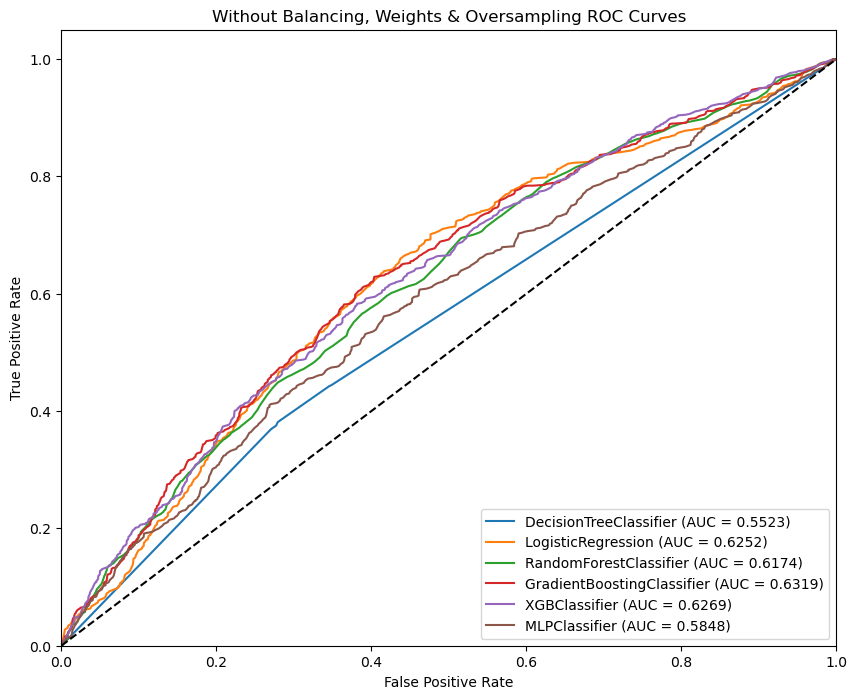

In [8]:
# step two - multi_label version(1): without balancing with weights or oversampling
class Multi_classifier:
    def __init__(self, model):
        self.model = model

    def readmission_multi_classifier(self):
        features = final_episodes2.iloc[:, 1:-2].columns

        X = final_episodes2[features]
        ym = final_episodes2["multi_label"]

        print("Features:\n", X.columns)
        print(X.shape)

        X.fillna(0, inplace=True)
        X = X[~ym.isna()]
        ym = ym.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, ym, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        # Creating a classifier without making data balanced
        print(self.model)
        if self.model == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(random_state=42)
        elif self.model == "LogisticRegression":
            self.model = LogisticRegression(random_state=42, max_iter=1000)
        elif self.model == "RandomForestClassifier":
            self.model = RandomForestClassifier(random_state=42)
        elif self.model == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(n_estimators=100, random_state=42)
        elif self.model == "XGBClassifier":
            self.model = XGBClassifier(random_state=42)
        elif self.model == "MLPClassifier":
            self.model = MLPClassifier(random_state=42, max_iter=1000)

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer_balanced_accuracy = make_scorer(balanced_accuracy_score)
        scorer_f1 = make_scorer(f1_score, average="weighted")

        # Perform cross-validation for balanced accuracy
        cv_scores_balanced_accuracy = cross_val_score(
            self.model,
            X_train_val_scaled,
            y_train_val,
            cv=cv,
            scoring=scorer_balanced_accuracy,
        )

        # Perform cross-validation for F1 score
        cv_scores_f1 = cross_val_score(
            self.model,
            X_train_val_scaled,
            y_train_val,
            cv=cv,
            scoring=scorer_f1,
        )

        # Train the final model on the entire training set
        self.model.fit(X_train_val_scaled, y_train_val)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Predict for whole data and save the DataFrame as a .csv file
        predicted_ML_df = pd.DataFrame()
        predicted_ML_df["predicted_Multi_label"] = self.model.predict(
            scaler.transform(X)
        )

        predicted_ML_df = pd.concat(
            [
                df.reset_index(drop=True)
                for df in [
                    final_episodes2_episode_id,
                    X,
                    predicted_ML_df["predicted_Multi_label"],
                ]
            ],
            axis=1,
        )
        predicted_ML_df.to_csv(predicted_start_path + "Initial_predicted_ML_df.csv")

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Multi_conf_matrix_test = conf_matrix_test

        Multi_report = classification_report(y_test, predictions_test)
        print(Multi_report)

        # Additional code for AUC-ROC plotting per class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        n_classes = ym.nunique()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(
                y_test == i, self.model.predict_proba(X_test_scaled)[:, i]
            )
            roc_auc[i] = auc(fpr[i], tpr[i])

        return Multi_conf_matrix_test, Multi_report, fpr, tpr, roc_auc


# Create instances of the multi-class classifier with different models
models = [
    Multi_classifier("DecisionTreeClassifier"),
    Multi_classifier("LogisticRegression"),
    Multi_classifier("RandomForestClassifier"),
    Multi_classifier("GradientBoostingClassifier"),
    Multi_classifier("XGBClassifier"),
    Multi_classifier("MLPClassifier"),
]
plt.figure(figsize=(10, 8))
for model in models:
    conf_matrix, report, fpr, tpr, roc_auc = model.readmission_multi_classifier()

    # Get the number of classes (you can use any of the dictionaries since they share keys)
    n_classes = len(fpr)

    # Assuming you want to plot only the micro-average ROC curve (combining all classes)
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    roc_auc_model = auc(all_fpr, mean_tpr)
    model_name = type(model.model).__name__
    plt.plot(all_fpr, mean_tpr, label=f"{model_name} (AUC = %0.4f)" % roc_auc_model)

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Without Balancing, Weights & Oversampling ROC Curves")
plt.legend(loc="lower right")
plt.savefig(
    "1_MultiClass_Without_balancing_weights_oversampling_ROC_curves.png",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlanning_ratio',
       'Advisory_ratio',
       ...
       'G03DA02', 'B03BA03', 'G03FB05', 'S01AA13', 'A11JB', 'M01AE01',
       'N05AE04', 'N06AA09', 'R03AC03', 'B03BA01'],
      dtype='object', length=216)
(3426, 216)
Model is DecisionTreeClassifier


/mnt/scratch/tmp/ipykernel_20905/25689644.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.37537402 0.38332924 0.35991508 0.42357904 0.36792207]
Mean Balanced Accuracy: 0.3820238872737415
Cross-Validation F1 Scores:
[0.37754786 0.3849802  0.364823   0.42545405 0.36987836]
Mean F1 Score: 0.384536691831017
Balanced Accuracy (Test): 0.38801707551707554
F1 Score (Test): 0.38838319820999306
Confusion Matrix (Test):
[[ 59  83  56]
 [ 81  99  84]
 [ 44  70 110]]
              precision    recall  f1-score   support

           0       0.32      0.30      0.31       198
           1       0.39      0.38      0.38       264
           2       0.44      0.49      0.46       224

    accuracy                           0.39       686
   macro avg       0.38      0.39      0.39       686
weighted avg       0.39      0.39      0.39       686

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlann

/mnt/scratch/tmp/ipykernel_20905/25689644.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.46749482 0.44589255 0.41907569 0.48008826 0.47788722]
Mean Balanced Accuracy: 0.4580877101417122
Cross-Validation F1 Scores:
[0.44213501 0.42033813 0.38963878 0.45394889 0.44925225]
Mean F1 Score: 0.4310626128464552
Balanced Accuracy (Test): 0.44402356902356904
F1 Score (Test): 0.4187890925242083
Confusion Matrix (Test):
[[ 89  52  57]
 [ 83  68 113]
 [ 41  43 140]]
              precision    recall  f1-score   support

           0       0.42      0.45      0.43       198
           1       0.42      0.26      0.32       264
           2       0.45      0.62      0.52       224

    accuracy                           0.43       686
   macro avg       0.43      0.44      0.43       686
weighted avg       0.43      0.43      0.42       686

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlann

/mnt/scratch/tmp/ipykernel_20905/25689644.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.43233323 0.4182838  0.39615047 0.45914676 0.45571136]
Mean Balanced Accuracy: 0.4323251234255916
Cross-Validation F1 Scores:
[0.43515886 0.41787077 0.39365052 0.4586182  0.45644256]
Mean F1 Score: 0.4323481818560804
Balanced Accuracy (Test): 0.45287698412698413
F1 Score (Test): 0.45410426532048215
Confusion Matrix (Test):
[[ 66  95  37]
 [ 62 121  81]
 [ 28  69 127]]
              precision    recall  f1-score   support

           0       0.42      0.33      0.37       198
           1       0.42      0.46      0.44       264
           2       0.52      0.57      0.54       224

    accuracy                           0.46       686
   macro avg       0.46      0.45      0.45       686
weighted avg       0.45      0.46      0.45       686

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlan

/mnt/scratch/tmp/ipykernel_20905/25689644.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.44937245 0.45480694 0.42438034 0.47837025 0.4759901 ]
Mean Balanced Accuracy: 0.45658401544
Cross-Validation F1 Scores:
[0.43609383 0.42891957 0.39825119 0.44362864 0.43973395]
Mean F1 Score: 0.4293254368693006
Balanced Accuracy (Test): 0.46330868205868203
F1 Score (Test): 0.43622123120395745
Confusion Matrix (Test):
[[ 91  49  58]
 [ 87  70 107]
 [ 27  48 149]]
              precision    recall  f1-score   support

           0       0.44      0.46      0.45       198
           1       0.42      0.27      0.32       264
           2       0.47      0.67      0.55       224

    accuracy                           0.45       686
   macro avg       0.45      0.46      0.44       686
weighted avg       0.44      0.45      0.44       686

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlanning_

/mnt/scratch/tmp/ipykernel_20905/25689644.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.45050239 0.44370285 0.43141734 0.43768537 0.44333508]
Mean Balanced Accuracy: 0.44132860649780986
Cross-Validation F1 Scores:
[0.4522399  0.43643502 0.42969244 0.43559412 0.44056316]
Mean F1 Score: 0.4389049269527684
Balanced Accuracy (Test): 0.4403860028860029
F1 Score (Test): 0.4353717132252144
Confusion Matrix (Test):
[[ 81  82  35]
 [ 81  97  86]
 [ 35  67 122]]
              precision    recall  f1-score   support

           0       0.41      0.41      0.41       198
           1       0.39      0.37      0.38       264
           2       0.50      0.54      0.52       224

    accuracy                           0.44       686
   macro avg       0.44      0.44      0.44       686
weighted avg       0.43      0.44      0.44       686

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlann

/mnt/scratch/tmp/ipykernel_20905/25689644.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.42939257 0.42860301 0.39680902 0.40556755 0.42561378]
Mean Balanced Accuracy: 0.41719718605117995
Cross-Validation F1 Scores:
[0.43490943 0.43178634 0.39551204 0.41039622 0.428945  ]
Mean F1 Score: 0.42030980655643224
Balanced Accuracy (Test): 0.42547498797498795
F1 Score (Test): 0.42452506822251496
Confusion Matrix (Test):
[[ 76  78  44]
 [ 63 106  95]
 [ 43  71 110]]
              precision    recall  f1-score   support

           0       0.42      0.38      0.40       198
           1       0.42      0.40      0.41       264
           2       0.44      0.49      0.47       224

    accuracy                           0.43       686
   macro avg       0.43      0.43      0.42       686
weighted avg       0.42      0.43      0.42       686



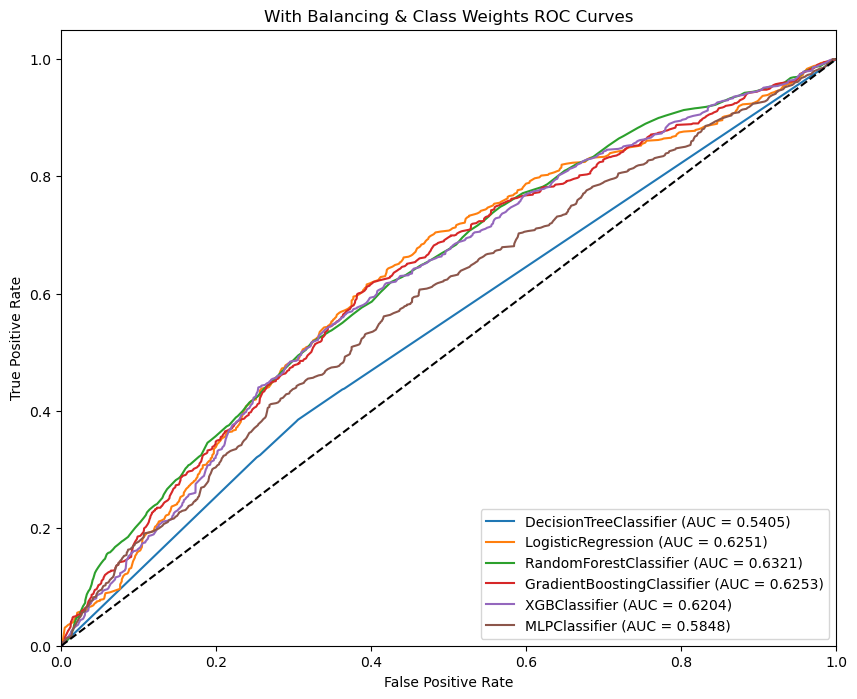

In [9]:
# step two - multi_label version(2): with balancing with balanced class_weightx
class Multi_classifier:
    def __init__(self, model):
        self.model = model

    def readmission_multi_classifier(self):
        features = final_episodes2.iloc[:, 1:-2].columns

        X = final_episodes2[features]
        ym = final_episodes2["multi_label"]

        print("Features:\n", X.columns)
        print(X.shape)

        X.fillna(0, inplace=True)
        X = X[~ym.isna()]
        ym = ym.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, ym, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        model_type = self.model

        print("Model is", self.model)
        if model_type == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(
                class_weight="balanced", random_state=42
            )
        elif model_type == "LogisticRegression":
            self.model = LogisticRegression(
                random_state=42, class_weight="balanced", max_iter=1000
            )
        elif model_type == "RandomForestClassifier":
            self.model = RandomForestClassifier(
                class_weight="balanced", random_state=42
            )
        elif model_type == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(
                n_estimators=100, learning_rate=0.1, random_state=42
            )
            sample_weight = compute_sample_weight(
                class_weight="balanced", y=y_train_val
            )
        elif model_type == "XGBClassifier":
            self.model = XGBClassifier(random_state=42)
            sample_weight = compute_sample_weight(
                class_weight="balanced", y=y_train_val
            )
        elif model_type == "MLPClassifier":
            self.model = MLPClassifier(
                random_state=42, learning_rate="adaptive", max_iter=1000
            )

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer_balanced_accuracy = make_scorer(balanced_accuracy_score)
        scorer_f1 = make_scorer(f1_score, average="weighted")

        if model_type in ["GradientBoostingClassifier", "XGBClassifier"]:
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
                fit_params={"sample_weight": sample_weight},
            )
            cv_scores_f1 = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_f1,
                fit_params={"sample_weight": sample_weight},
            )
        else:
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
            )
            cv_scores_f1 = cross_val_score(
                self.model, X_train_val_scaled, y_train_val, cv=cv, scoring=scorer_f1
            )

        # Train the final model on the entire training set
        if model_type in ["GradientBoostingClassifier", "XGBClassifier"]:
            self.model.fit(X_train_val_scaled, y_train_val, sample_weight=sample_weight)
        else:
            self.model.fit(X_train_val_scaled, y_train_val)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Predict for whole data and save the DataFrame as a .csv file
        predicted_ML_df = pd.DataFrame()
        predicted_ML_df["predicted_Multi_label"] = self.model.predict(
            scaler.transform(X)
        )

        predicted_ML_df = pd.concat(
            [
                df.reset_index(drop=True)
                for df in [
                    final_episodes2_episode_id,
                    X,
                    predicted_ML_df["predicted_Multi_label"],
                ]
            ],
            axis=1,
        )
        predicted_ML_df.to_csv(predicted_start_path + "Balanced_predicted_ML_df.csv")

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Multi_conf_matrix_test = conf_matrix_test

        Multi_report = classification_report(y_test, predictions_test)
        print(Multi_report)

        # Additional code for AUC-ROC plotting per class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        n_classes = ym.nunique()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(
                y_test == i, self.model.predict_proba(X_test_scaled)[:, i]
            )
            roc_auc[i] = auc(fpr[i], tpr[i])
        return Multi_conf_matrix_test, Multi_report, fpr, tpr, roc_auc


# Create instances of the multi-class classifier with different models
models = [
    Multi_classifier("DecisionTreeClassifier"),
    Multi_classifier("LogisticRegression"),
    Multi_classifier("RandomForestClassifier"),
    Multi_classifier("GradientBoostingClassifier"),
    Multi_classifier("XGBClassifier"),
    Multi_classifier("MLPClassifier"),
]
plt.figure(figsize=(10, 8))
for model in models:
    conf_matrix, report, fpr, tpr, roc_auc = model.readmission_multi_classifier()

    # Get the number of classes (you can use any of the dictionaries since they share keys)
    n_classes = len(fpr)

    # Assuming you want to plot only the micro-average ROC curve (combining all classes)
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    roc_auc_model = auc(all_fpr, mean_tpr)
    model_name = type(model.model).__name__
    plt.plot(all_fpr, mean_tpr, label=f"{model_name} (AUC = %0.4f)" % roc_auc_model)

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("With Balancing & Class Weights ROC Curves")
plt.legend(loc="lower right")
plt.savefig(
    "2_MultiClass_WithBalancing_BalancedClass_Weight_ROC_Curves.png",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlanning_ratio',
       'Advisory_ratio',
       ...
       'G03DA02', 'B03BA03', 'G03FB05', 'S01AA13', 'A11JB', 'M01AE01',
       'N05AE04', 'N06AA09', 'R03AC03', 'B03BA01'],
      dtype='object', length=216)
(3426, 216)
DecisionTreeClassifier


/mnt/scratch/tmp/ipykernel_20905/1905887364.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.53645528 0.50701873 0.50549161 0.52927857 0.5105469 ]
Mean Balanced Accuracy: 0.5177582186112992
Cross-Validation F1 Scores:
[0.53581627 0.50218528 0.50260745 0.52637074 0.50557342]
Mean F1 Score: 0.514510634287206
Balanced Accuracy (Test): 0.4087151274651275
F1 Score (Test): 0.4064966855696244
Confusion Matrix (Test):
[[ 80  70  48]
 [ 88  98  78]
 [ 44  79 101]]
              precision    recall  f1-score   support

           0       0.38      0.40      0.39       198
           1       0.40      0.37      0.38       264
           2       0.44      0.45      0.45       224

    accuracy                           0.41       686
   macro avg       0.41      0.41      0.41       686
weighted avg       0.41      0.41      0.41       686

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlannin

/mnt/scratch/tmp/ipykernel_20905/1905887364.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.45766193 0.4849921  0.50527345 0.47831942 0.44250357]
Mean Balanced Accuracy: 0.4737500940344542
Cross-Validation F1 Scores:
[0.43917729 0.47194924 0.4957355  0.46771067 0.42283722]
Mean F1 Score: 0.4594819866178782
Balanced Accuracy (Test): 0.4374549062049062
F1 Score (Test): 0.4110755840190808
Confusion Matrix (Test):
[[ 90  50  58]
 [ 89  65 110]
 [ 45  42 137]]
              precision    recall  f1-score   support

           0       0.40      0.45      0.43       198
           1       0.41      0.25      0.31       264
           2       0.45      0.61      0.52       224

    accuracy                           0.43       686
   macro avg       0.42      0.44      0.42       686
weighted avg       0.42      0.43      0.41       686

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlanni

/mnt/scratch/tmp/ipykernel_20905/1905887364.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.53343113 0.58160686 0.55608215 0.54973294 0.55183179]
Mean Balanced Accuracy: 0.5545369743474009
Cross-Validation F1 Scores:
[0.52690532 0.57914825 0.55345421 0.54700003 0.54266141]
Mean F1 Score: 0.5498338444838845
Balanced Accuracy (Test): 0.4624969937469938
F1 Score (Test): 0.4551651941857023
Confusion Matrix (Test):
[[ 91  64  43]
 [ 73 100  91]
 [ 33  68 123]]
              precision    recall  f1-score   support

           0       0.46      0.46      0.46       198
           1       0.43      0.38      0.40       264
           2       0.48      0.55      0.51       224

    accuracy                           0.46       686
   macro avg       0.46      0.46      0.46       686
weighted avg       0.46      0.46      0.46       686

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlanni

/mnt/scratch/tmp/ipykernel_20905/1905887364.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.47188746 0.51982246 0.50048898 0.47040548 0.46952531]
Mean Balanced Accuracy: 0.4864259384638531
Cross-Validation F1 Scores:
[0.45585876 0.50796643 0.48703126 0.46202793 0.44374466]
Mean F1 Score: 0.4713258070887297
Balanced Accuracy (Test): 0.46042267917267915
F1 Score (Test): 0.4239200899902964
Confusion Matrix (Test):
[[ 94  41  63]
 [ 92  59 113]
 [ 29  42 153]]
              precision    recall  f1-score   support

           0       0.44      0.47      0.46       198
           1       0.42      0.22      0.29       264
           2       0.47      0.68      0.55       224

    accuracy                           0.45       686
   macro avg       0.44      0.46      0.43       686
weighted avg       0.44      0.45      0.42       686

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlann

/mnt/scratch/tmp/ipykernel_20905/1905887364.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.50966674 0.5403295  0.54977808 0.51810727 0.51861882]
Mean Balanced Accuracy: 0.5273000827503198
Cross-Validation F1 Scores:
[0.50633667 0.53817489 0.54715943 0.51822504 0.50288268]
Mean F1 Score: 0.5225557411750346
Balanced Accuracy (Test): 0.39891474266474264
F1 Score (Test): 0.3875355912753187
Confusion Matrix (Test):
[[ 73  73  52]
 [ 87  76 101]
 [ 34  69 121]]
              precision    recall  f1-score   support

           0       0.38      0.37      0.37       198
           1       0.35      0.29      0.32       264
           2       0.44      0.54      0.49       224

    accuracy                           0.39       686
   macro avg       0.39      0.40      0.39       686
weighted avg       0.39      0.39      0.39       686

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlann

/mnt/scratch/tmp/ipykernel_20905/1905887364.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.53657564 0.54818325 0.4975852  0.46899872 0.51678327]
Mean Balanced Accuracy: 0.5136252162792447
Cross-Validation F1 Scores:
[0.53461752 0.53474091 0.49832657 0.46603444 0.51683949]
Mean F1 Score: 0.5101117862256009
Balanced Accuracy (Test): 0.40597943722943725
F1 Score (Test): 0.39547121810063945
Confusion Matrix (Test):
[[99 67 32]
 [97 87 80]
 [63 74 87]]
              precision    recall  f1-score   support

           0       0.38      0.50      0.43       198
           1       0.38      0.33      0.35       264
           2       0.44      0.39      0.41       224

    accuracy                           0.40       686
   macro avg       0.40      0.41      0.40       686
weighted avg       0.40      0.40      0.40       686



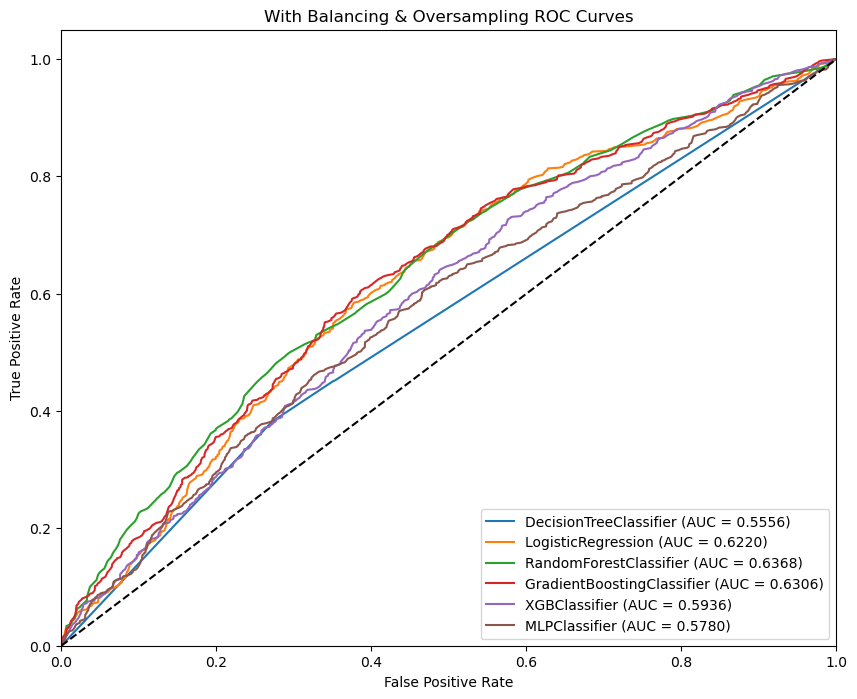

In [10]:
# step two - multi_label version(3): with balancing with oversampling
class Multi_classifier:
    def __init__(self, model):
        self.model = model

    def readmission_multi_classifier(self):
        features = final_episodes2.iloc[:, 1:-2].columns

        X = final_episodes2[features]
        ym = final_episodes2["multi_label"]

        print("Features:\n", X.columns)
        print(X.shape)

        X.fillna(0, inplace=True)
        X = X[~ym.isna()]
        ym = ym.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, ym, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        # Creating a classifier
        print(self.model)
        if self.model == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(random_state=42)
        elif self.model == "LogisticRegression":
            self.model = LogisticRegression(random_state=42, max_iter=1000)
        elif self.model == "RandomForestClassifier":
            self.model = RandomForestClassifier(random_state=42)
        elif self.model == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(n_estimators=100, random_state=42)
        elif self.model == "XGBClassifier":
            self.model = XGBClassifier(random_state=42)
        elif self.model == "MLPClassifier":
            self.model = MLPClassifier(random_state=42, max_iter=1000)

        # Oversampling and fitting
        ros = RandomOverSampler(random_state=0)
        X_resampled, y_resampled = ros.fit_resample(X_train_val, y_train_val)
        X_train_val_scaled_resampled = scaler.fit_transform(
            X_resampled
        )  # rescale after resampling

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer = make_scorer(balanced_accuracy_score)

        # Perform cross-validation for balanced accuracy
        cv_scores_balanced_accuracy = cross_val_score(
            self.model, X_train_val_scaled_resampled, y_resampled, cv=cv, scoring=scorer
        )

        # Perform cross-validation for F1 score
        f1_scorer = make_scorer(f1_score, average="weighted")
        cv_scores_f1 = cross_val_score(
            self.model,
            X_train_val_scaled_resampled,
            y_resampled,
            cv=cv,
            scoring=f1_scorer,
        )

        # Train the final model on the entire resampled training set
        self.model.fit(X_train_val_scaled_resampled, y_resampled)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Predict for whole data and save the DataFrame as a .csv file
        predicted_ML_df = pd.DataFrame()
        predicted_ML_df["predicted_Multi_label"] = self.model.predict(
            scaler.transform(X)
        )

        predicted_ML_df = pd.concat(
            [
                df.reset_index(drop=True)
                for df in [
                    final_episodes2_episode_id,
                    X,
                    predicted_ML_df["predicted_Multi_label"],
                ]
            ],
            axis=1,
        )
        predicted_ML_df.to_csv(
            predicted_start_path + "Oversampling_predicted_ML_df.csv"
        )

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Multi_conf_matrix_test = conf_matrix_test

        Multi_report = classification_report(y_test, predictions_test)
        print(Multi_report)

        # Additional code for AUC-ROC plotting per class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        n_classes = ym.nunique()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(
                y_test == i, self.model.predict_proba(X_test_scaled)[:, i]
            )
            roc_auc[i] = auc(fpr[i], tpr[i])
        return Multi_conf_matrix_test, Multi_report, fpr, tpr, roc_auc


# Create instances of the multi-class classifier with different models
models = [
    Multi_classifier("DecisionTreeClassifier"),
    Multi_classifier("LogisticRegression"),
    Multi_classifier("RandomForestClassifier"),
    Multi_classifier("GradientBoostingClassifier"),
    Multi_classifier("XGBClassifier"),
    Multi_classifier("MLPClassifier"),
]
plt.figure(figsize=(10, 8))
for model in models:
    conf_matrix, report, fpr, tpr, roc_auc = model.readmission_multi_classifier()

    # Get the number of classes (you can use any of the dictionaries since they share keys)
    n_classes = len(fpr)

    # Assuming you want to plot only the micro-average ROC curve (combining all classes)
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    roc_auc_model = auc(all_fpr, mean_tpr)
    model_name = type(model.model).__name__
    plt.plot(all_fpr, mean_tpr, label=f"{model_name} (AUC = %0.4f)" % roc_auc_model)

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("With Balancing & Oversampling ROC Curves")
plt.legend(loc="lower right")
plt.savefig(
    "3_MultiClass_WithBalancing_Oversampling_ROC_Curves.png",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

### 3 (a). Cobine all for binary classifier

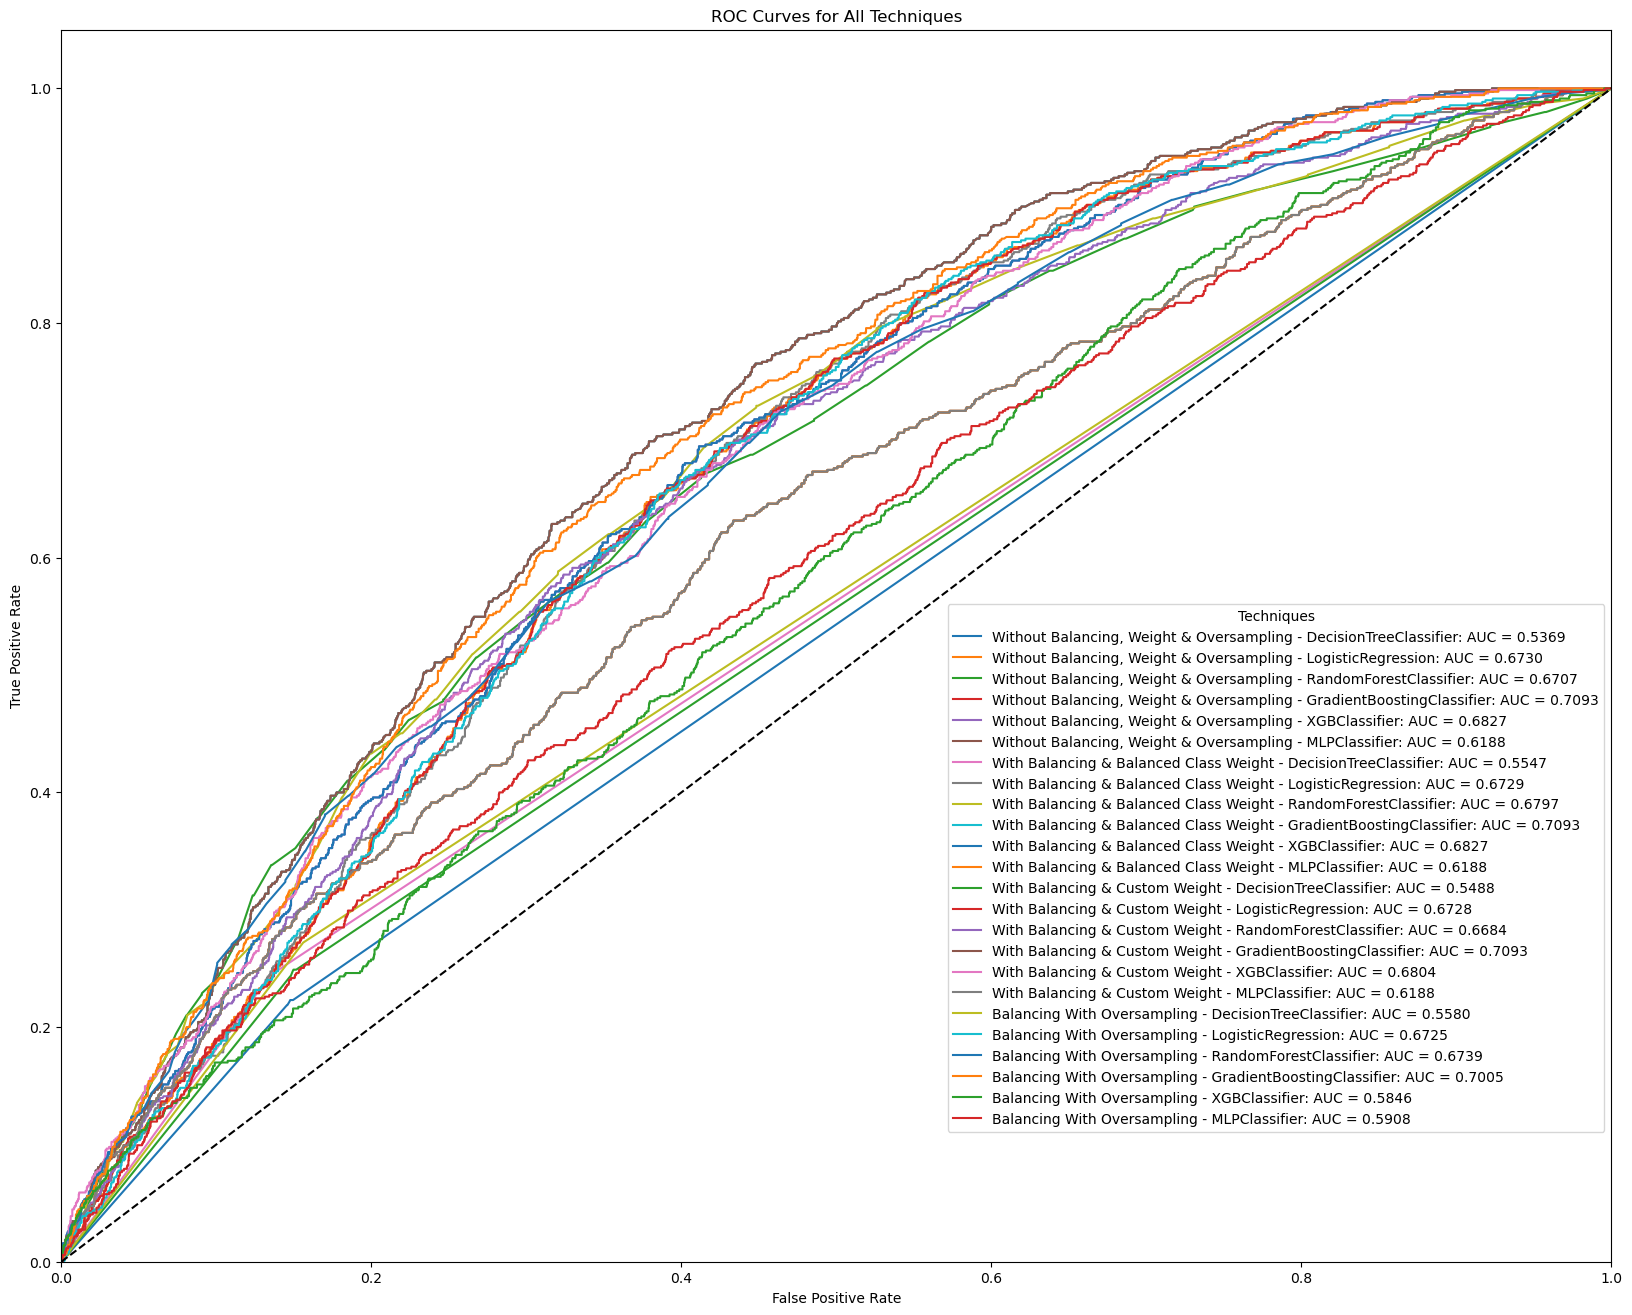

In [5]:
# combined ROC plot for all the models of binary classifier
class Binary_classifier:
    def __init__(self, model, version):
        self.model = model
        self.version = version

    def readmission_noreadmission_binary_classifier(self):
        X = final_episodes1.iloc[:, 1:-1]
        yb = final_episodes1["binary_label"]

        X.fillna(0, inplace=True)
        X = X[~yb.isna()]
        yb = yb.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, yb, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        model_type = self.model

        if model_type == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(random_state=42)
        elif model_type == "LogisticRegression":
            self.model = LogisticRegression(random_state=42, max_iter=1000)
        elif model_type == "RandomForestClassifier":
            self.model = RandomForestClassifier(random_state=42)
        elif model_type == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(n_estimators=100, random_state=42)
        elif model_type == "XGBClassifier":
            self.model = XGBClassifier(random_state=42)
        elif model_type == "MLPClassifier":
            self.model = MLPClassifier(random_state=42, max_iter=1000)

        # Adjustments based on versions
        if self.version == 2:  # with balancing with balanced class_weight
            if model_type in [
                "DecisionTreeClassifier",
                "LogisticRegression",
                "RandomForestClassifier",
            ]:
                self.model.set_params(class_weight="balanced")
        elif self.version == 3:  # with balancing with Custom weighting
            wl1 = 0.95
            wl0 = wl1 / (counts[0] / counts[1])
            wd1 = (max(counts) / counts[1]).round(2)
            wd0 = (max(counts) / counts[0]).round(2)
            w_neg = 0.0001
            w_pos = 1096.63
            GB1 = counts[0] / counts[1]
            GB0 = counts[0] / counts[0]
            sample_weight = np.ones(y_train_val.shape)
            sample_weight[y_train_val == 0] = GB0
            sample_weight[y_train_val == 1] = GB1
            ratio = float(counts[0] / counts[1])
            if model_type == "DecisionTreeClassifier":
                self.model.set_params(class_weight={0: wd0, 1: wd1})
            elif model_type == "LogisticRegression":
                self.model.set_params(solver="newton-cg", class_weight={0: wl0, 1: wl1})
            elif model_type == "RandomForestClassifier":
                self.model.set_params(class_weight={0: w_neg, 1: w_pos})
            elif model_type == "XGBClassifier":
                self.model.set_params(scale_pos_weight=ratio)
        elif self.version == 4:  # balancing with oversampling
            ros = RandomOverSampler(random_state=0)
            X_resampled, y_resampled = ros.fit_resample(X_train_val, y_train_val)
            X_train_val_scaled_resampled = scaler.fit_transform(X_resampled)
            X_train_val_scaled = X_train_val_scaled_resampled
            y_train_val = y_resampled

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer_balanced_accuracy = make_scorer(balanced_accuracy_score)
        scorer_f1 = make_scorer(f1_score, average="weighted")

        # Perform cross-validation
        cv_scores_balanced_accuracy = cross_val_score(
            self.model,
            X_train_val_scaled,
            y_train_val,
            cv=cv,
            scoring=scorer_balanced_accuracy,
        )
        cv_scores_f1 = cross_val_score(
            self.model, X_train_val_scaled, y_train_val, cv=cv, scoring=scorer_f1
        )

        # Train the final model on the entire training set
        self.model.fit(X_train_val_scaled, y_train_val)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)
        Binary_report = classification_report(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        # Additional code for AUC-ROC and AUC calculation
        y_proba = self.model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        auc_score = roc_auc  # AUC is the same as the area under the ROC curve
        return Binary_report, conf_matrix_test, fpr, tpr, auc_score


# Define versions and titles for each technique
versions = [
    (1, "Without Balancing Weight or Oversampling"),
    (2, "With Balance Class Weight"),
    (3, "With Custom Weight"),
    (4, "With Oversampling"),
]

# Initialize the plot
plt.figure(figsize=(20, 16))

# Create instances of the binary classifier with different models and versions
for version, title in versions:
    models = [
        Binary_classifier("DecisionTreeClassifier", version),
        Binary_classifier("LogisticRegression", version),
        Binary_classifier("RandomForestClassifier", version),
        Binary_classifier("GradientBoostingClassifier", version),
        Binary_classifier("XGBClassifier", version),
        Binary_classifier("MLPClassifier", version),
    ]

    for model in models:
        report, conf_matrix, fpr, tpr, auc_score = (
            model.readmission_noreadmission_binary_classifier()
        )
        plt.plot(
            fpr,
            tpr,
            label=f"{title} - {model.model.__class__.__name__}: AUC = {auc_score:.4f}",
        )

# Add plot elements
plt.plot([0, 1], [0, 1], "k--")  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Techniques")
plt.legend(loc="lower right", bbox_to_anchor=(1, 0.1), title="Techniques")
plt.savefig("BinaryCombined_ROC_Curves.png", bbox_inches="tight", dpi=400)
plt.show()

## 3. Combine all three tehcnique ROC into one plot 

/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.36793113 0.39183891 0.36223228 0.4036837  0.37455067]
Mean Balanced Accuracy: 0.38004733578008626
Cross-Validation F1 Scores:
[0.3715473  0.39538444 0.36598907 0.405772   0.37119999]
Mean F1 Score: 0.3819785605794029
Balanced Accuracy (Test): 0.4013347763347763
F1 Score (Test): 0.4025368614668137
Confusion Matrix (Test):
[[ 72  77  49]
 [ 81 104  79]
 [ 54  70 100]]
              precision    recall  f1-score   support

           0       0.35      0.36      0.36       198
           1       0.41      0.39      0.40       264
           2       0.44      0.45      0.44       224

    accuracy                           0.40       686
   macro avg       0.40      0.40      0.40       686
weighted avg       0.40      0.40      0.40       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.44089319 0.43674188 0.44682832 0.45842878 0.47735065]
Mean Balanced Accuracy: 0.452048563660785
Cross-Validation F1 Scores:
[0.43739925 0.43272491 0.44100028 0.45062096 0.46762619]
Mean F1 Score: 0.4458743181725765
Balanced Accuracy (Test): 0.4298190235690236
F1 Score (Test): 0.42676367578875896
Confusion Matrix (Test):
[[ 50  96  52]
 [ 48 117  99]
 [ 26  65 133]]
              precision    recall  f1-score   support

           0       0.40      0.25      0.31       198
           1       0.42      0.44      0.43       264
           2       0.47      0.59      0.52       224

    accuracy                           0.44       686
   macro avg       0.43      0.43      0.42       686
weighted avg       0.43      0.44      0.43       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.44277409 0.42326327 0.41014025 0.42771764 0.43785846]
Mean Balanced Accuracy: 0.4283507430814618
Cross-Validation F1 Scores:
[0.44606771 0.42254123 0.41000021 0.42734717 0.44021492]
Mean F1 Score: 0.42923424672121585
Balanced Accuracy (Test): 0.42562530062530063
F1 Score (Test): 0.42545322267461333
Confusion Matrix (Test):
[[ 65  94  39]
 [ 57 109  98]
 [ 22  82 120]]
              precision    recall  f1-score   support

           0       0.45      0.33      0.38       198
           1       0.38      0.41      0.40       264
           2       0.47      0.54      0.50       224

    accuracy                           0.43       686
   macro avg       0.43      0.43      0.43       686
weighted avg       0.43      0.43      0.43       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.44630312 0.43847773 0.44619785 0.4829877  0.43845105]
Mean Balanced Accuracy: 0.45048348947626254
Cross-Validation F1 Scores:
[0.44948239 0.43481896 0.44096519 0.48054262 0.43287611]
Mean F1 Score: 0.4477370547339907
Balanced Accuracy (Test): 0.45224567099567103
F1 Score (Test): 0.44776904018909913
Confusion Matrix (Test):
[[ 57  88  53]
 [ 45 116 103]
 [ 15  68 141]]
              precision    recall  f1-score   support

           0       0.49      0.29      0.36       198
           1       0.43      0.44      0.43       264
           2       0.47      0.63      0.54       224

    accuracy                           0.46       686
   macro avg       0.46      0.45      0.45       686
weighted avg       0.46      0.46      0.45       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.41212993 0.42059983 0.42741341 0.43044985 0.43301576]
Mean Balanced Accuracy: 0.4247217558612223
Cross-Validation F1 Scores:
[0.41674802 0.42272448 0.42907063 0.43423713 0.43564316]
Mean F1 Score: 0.4276846845184089
Balanced Accuracy (Test): 0.4310365560365561
F1 Score (Test): 0.4330022397757816
Confusion Matrix (Test):
[[ 65  89  44]
 [ 62 118  84]
 [ 31  77 116]]
              precision    recall  f1-score   support

           0       0.41      0.33      0.37       198
           1       0.42      0.45      0.43       264
           2       0.48      0.52      0.50       224

    accuracy                           0.44       686
   macro avg       0.43      0.43      0.43       686
weighted avg       0.43      0.44      0.43       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.42939257 0.42860301 0.39680902 0.40556755 0.42561378]
Mean Balanced Accuracy: 0.41719718605117995
Cross-Validation F1 Scores:
[0.43490943 0.43178634 0.39551204 0.41039622 0.428945  ]
Mean F1 Score: 0.42030980655643224
Balanced Accuracy (Test): 0.42547498797498795
F1 Score (Test): 0.42452506822251496
Confusion Matrix (Test):
[[ 76  78  44]
 [ 63 106  95]
 [ 43  71 110]]
              precision    recall  f1-score   support

           0       0.42      0.38      0.40       198
           1       0.42      0.40      0.41       264
           2       0.44      0.49      0.47       224

    accuracy                           0.43       686
   macro avg       0.43      0.43      0.42       686
weighted avg       0.42      0.43      0.42       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.37537402 0.38332924 0.35991508 0.42357904 0.36792207]
Mean Balanced Accuracy: 0.3820238872737415
Cross-Validation F1 Scores:
[0.37754786 0.3849802  0.364823   0.42545405 0.36987836]
Mean F1 Score: 0.384536691831017
Balanced Accuracy (Test): 0.38801707551707554
F1 Score (Test): 0.38838319820999306
Confusion Matrix (Test):
[[ 59  83  56]
 [ 81  99  84]
 [ 44  70 110]]
              precision    recall  f1-score   support

           0       0.32      0.30      0.31       198
           1       0.39      0.38      0.38       264
           2       0.44      0.49      0.46       224

    accuracy                           0.39       686
   macro avg       0.38      0.39      0.39       686
weighted avg       0.39      0.39      0.39       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.46749482 0.44589255 0.41907569 0.48008826 0.47788722]
Mean Balanced Accuracy: 0.4580877101417122
Cross-Validation F1 Scores:
[0.44213501 0.42033813 0.38963878 0.45394889 0.44925225]
Mean F1 Score: 0.4310626128464552
Balanced Accuracy (Test): 0.44402356902356904
F1 Score (Test): 0.4187890925242083
Confusion Matrix (Test):
[[ 89  52  57]
 [ 83  68 113]
 [ 41  43 140]]
              precision    recall  f1-score   support

           0       0.42      0.45      0.43       198
           1       0.42      0.26      0.32       264
           2       0.45      0.62      0.52       224

    accuracy                           0.43       686
   macro avg       0.43      0.44      0.43       686
weighted avg       0.43      0.43      0.42       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.43233323 0.4182838  0.39615047 0.45914676 0.45571136]
Mean Balanced Accuracy: 0.4323251234255916
Cross-Validation F1 Scores:
[0.43515886 0.41787077 0.39365052 0.4586182  0.45644256]
Mean F1 Score: 0.4323481818560804
Balanced Accuracy (Test): 0.45287698412698413
F1 Score (Test): 0.45410426532048215
Confusion Matrix (Test):
[[ 66  95  37]
 [ 62 121  81]
 [ 28  69 127]]
              precision    recall  f1-score   support

           0       0.42      0.33      0.37       198
           1       0.42      0.46      0.44       264
           2       0.52      0.57      0.54       224

    accuracy                           0.46       686
   macro avg       0.46      0.45      0.45       686
weighted avg       0.45      0.46      0.45       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.44937245 0.45480694 0.42438034 0.47837025 0.4759901 ]
Mean Balanced Accuracy: 0.45658401544
Cross-Validation F1 Scores:
[0.43609383 0.42891957 0.39825119 0.44362864 0.43973395]
Mean F1 Score: 0.4293254368693006
Balanced Accuracy (Test): 0.45224567099567103
F1 Score (Test): 0.44776904018909913
Confusion Matrix (Test):
[[ 57  88  53]
 [ 45 116 103]
 [ 15  68 141]]
              precision    recall  f1-score   support

           0       0.49      0.29      0.36       198
           1       0.43      0.44      0.43       264
           2       0.47      0.63      0.54       224

    accuracy                           0.46       686
   macro avg       0.46      0.45      0.45       686
weighted avg       0.46      0.46      0.45       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.45050239 0.44370285 0.43141734 0.43768537 0.44333508]
Mean Balanced Accuracy: 0.44132860649780986
Cross-Validation F1 Scores:
[0.4522399  0.43643502 0.42969244 0.43559412 0.44056316]
Mean F1 Score: 0.4389049269527684
Balanced Accuracy (Test): 0.4310365560365561
F1 Score (Test): 0.4330022397757816
Confusion Matrix (Test):
[[ 65  89  44]
 [ 62 118  84]
 [ 31  77 116]]
              precision    recall  f1-score   support

           0       0.41      0.33      0.37       198
           1       0.42      0.45      0.43       264
           2       0.48      0.52      0.50       224

    accuracy                           0.44       686
   macro avg       0.43      0.43      0.43       686
weighted avg       0.43      0.44      0.43       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.42939257 0.42860301 0.39680902 0.40556755 0.42561378]
Mean Balanced Accuracy: 0.41719718605117995
Cross-Validation F1 Scores:
[0.43490943 0.43178634 0.39551204 0.41039622 0.428945  ]
Mean F1 Score: 0.42030980655643224
Balanced Accuracy (Test): 0.42547498797498795
F1 Score (Test): 0.42452506822251496
Confusion Matrix (Test):
[[ 76  78  44]
 [ 63 106  95]
 [ 43  71 110]]
              precision    recall  f1-score   support

           0       0.42      0.38      0.40       198
           1       0.42      0.40      0.41       264
           2       0.44      0.49      0.47       224

    accuracy                           0.43       686
   macro avg       0.43      0.43      0.42       686
weighted avg       0.42      0.43      0.42       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.53645528 0.50701873 0.50549161 0.52927857 0.5105469 ]
Mean Balanced Accuracy: 0.5177582186112992
Cross-Validation F1 Scores:
[0.53581627 0.50218528 0.50260745 0.52637074 0.50557342]
Mean F1 Score: 0.514510634287206
Balanced Accuracy (Test): 0.4087151274651275
F1 Score (Test): 0.4064966855696244
Confusion Matrix (Test):
[[ 80  70  48]
 [ 88  98  78]
 [ 44  79 101]]
              precision    recall  f1-score   support

           0       0.38      0.40      0.39       198
           1       0.40      0.37      0.38       264
           2       0.44      0.45      0.45       224

    accuracy                           0.41       686
   macro avg       0.41      0.41      0.41       686
weighted avg       0.41      0.41      0.41       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.45766193 0.4849921  0.50527345 0.47831942 0.44250357]
Mean Balanced Accuracy: 0.4737500940344542
Cross-Validation F1 Scores:
[0.43917729 0.47194924 0.4957355  0.46771067 0.42283722]
Mean F1 Score: 0.4594819866178782
Balanced Accuracy (Test): 0.4374549062049062
F1 Score (Test): 0.4110755840190808
Confusion Matrix (Test):
[[ 90  50  58]
 [ 89  65 110]
 [ 45  42 137]]
              precision    recall  f1-score   support

           0       0.40      0.45      0.43       198
           1       0.41      0.25      0.31       264
           2       0.45      0.61      0.52       224

    accuracy                           0.43       686
   macro avg       0.42      0.44      0.42       686
weighted avg       0.42      0.43      0.41       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.53343113 0.58160686 0.55608215 0.54973294 0.55183179]
Mean Balanced Accuracy: 0.5545369743474009
Cross-Validation F1 Scores:
[0.52690532 0.57914825 0.55345421 0.54700003 0.54266141]
Mean F1 Score: 0.5498338444838845
Balanced Accuracy (Test): 0.4624969937469938
F1 Score (Test): 0.4551651941857023
Confusion Matrix (Test):
[[ 91  64  43]
 [ 73 100  91]
 [ 33  68 123]]
              precision    recall  f1-score   support

           0       0.46      0.46      0.46       198
           1       0.43      0.38      0.40       264
           2       0.48      0.55      0.51       224

    accuracy                           0.46       686
   macro avg       0.46      0.46      0.46       686
weighted avg       0.46      0.46      0.46       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.47188746 0.51982246 0.50048898 0.47040548 0.46952531]
Mean Balanced Accuracy: 0.4864259384638531
Cross-Validation F1 Scores:
[0.45585876 0.50796643 0.48703126 0.46202793 0.44374466]
Mean F1 Score: 0.4713258070887297
Balanced Accuracy (Test): 0.46042267917267915
F1 Score (Test): 0.4239200899902964
Confusion Matrix (Test):
[[ 94  41  63]
 [ 92  59 113]
 [ 29  42 153]]
              precision    recall  f1-score   support

           0       0.44      0.47      0.46       198
           1       0.42      0.22      0.29       264
           2       0.47      0.68      0.55       224

    accuracy                           0.45       686
   macro avg       0.44      0.46      0.43       686
weighted avg       0.44      0.45      0.42       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.50966674 0.5403295  0.54977808 0.51810727 0.51861882]
Mean Balanced Accuracy: 0.5273000827503198
Cross-Validation F1 Scores:
[0.50633667 0.53817489 0.54715943 0.51822504 0.50288268]
Mean F1 Score: 0.5225557411750346
Balanced Accuracy (Test): 0.39891474266474264
F1 Score (Test): 0.3875355912753187
Confusion Matrix (Test):
[[ 73  73  52]
 [ 87  76 101]
 [ 34  69 121]]
              precision    recall  f1-score   support

           0       0.38      0.37      0.37       198
           1       0.35      0.29      0.32       264
           2       0.44      0.54      0.49       224

    accuracy                           0.39       686
   macro avg       0.39      0.40      0.39       686
weighted avg       0.39      0.39      0.39       686



/mnt/scratch/tmp/ipykernel_12212/2607203521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.53657564 0.54818325 0.4975852  0.46899872 0.51678327]
Mean Balanced Accuracy: 0.5136252162792447
Cross-Validation F1 Scores:
[0.53461752 0.53474091 0.49832657 0.46603444 0.51683949]
Mean F1 Score: 0.5101117862256009
Balanced Accuracy (Test): 0.40597943722943725
F1 Score (Test): 0.39547121810063945
Confusion Matrix (Test):
[[99 67 32]
 [97 87 80]
 [63 74 87]]
              precision    recall  f1-score   support

           0       0.38      0.50      0.43       198
           1       0.38      0.33      0.35       264
           2       0.44      0.39      0.41       224

    accuracy                           0.40       686
   macro avg       0.40      0.41      0.40       686
weighted avg       0.40      0.40      0.40       686



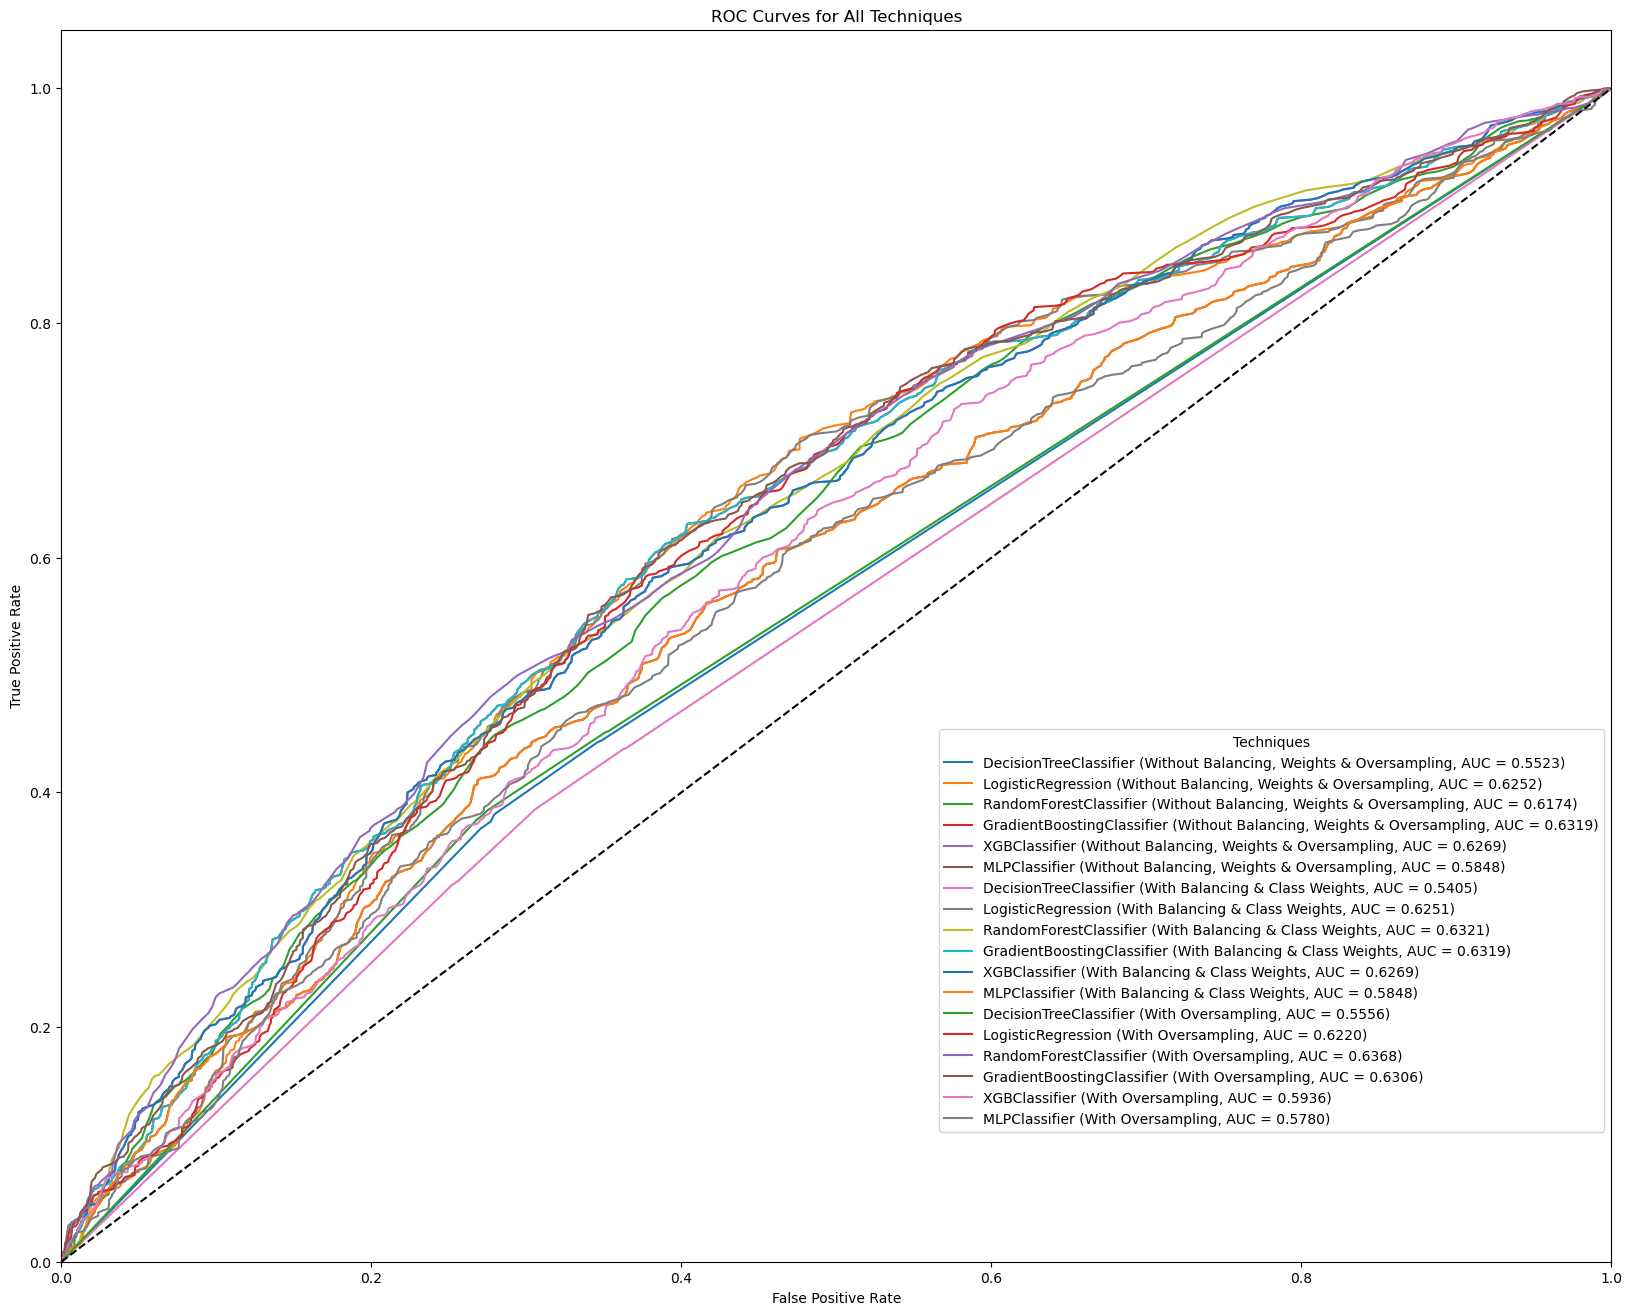

In [7]:
class Multi_classifier:
    def __init__(self, model, balancing_technique):
        self.model = model
        self.balancing_technique = balancing_technique

    def readmission_multi_classifier(self):
        features = final_episodes2.iloc[:, 1:-2].columns

        X = final_episodes2[features]
        ym = final_episodes2["multi_label"]

        X.fillna(0, inplace=True)
        X = X[~ym.isna()]
        ym = ym.dropna()

        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, ym, test_size=0.2, random_state=42
        )

        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        if self.balancing_technique == "none":
            if self.model == "DecisionTreeClassifier":
                self.model = DecisionTreeClassifier(random_state=42)
            elif self.model == "LogisticRegression":
                self.model = LogisticRegression(random_state=42, max_iter=1000)
            elif self.model == "RandomForestClassifier":
                self.model = RandomForestClassifier(random_state=42)
            elif self.model == "GradientBoostingClassifier":
                self.model = GradientBoostingClassifier(
                    n_estimators=100, random_state=42
                )
            elif self.model == "XGBClassifier":
                self.model = XGBClassifier(random_state=42)
            elif self.model == "MLPClassifier":
                self.model = MLPClassifier(random_state=42, max_iter=1000)

        elif self.balancing_technique == "balanced":
            if self.model == "DecisionTreeClassifier":
                self.model = DecisionTreeClassifier(
                    class_weight="balanced", random_state=42
                )
            elif self.model == "LogisticRegression":
                self.model = LogisticRegression(
                    random_state=42, class_weight="balanced", max_iter=1000
                )
            elif self.model == "RandomForestClassifier":
                self.model = RandomForestClassifier(
                    class_weight="balanced", random_state=42
                )
            elif self.model == "GradientBoostingClassifier":
                self.model = GradientBoostingClassifier(
                    n_estimators=100, learning_rate=0.1, random_state=42
                )
                sample_weight = compute_sample_weight(
                    class_weight="balanced", y=y_train_val
                )
            elif self.model == "XGBClassifier":
                self.model = XGBClassifier(random_state=42)
                sample_weight = compute_sample_weight(
                    class_weight="balanced", y=y_train_val
                )
            elif self.model == "MLPClassifier":
                self.model = MLPClassifier(
                    random_state=42, learning_rate="adaptive", max_iter=1000
                )

        elif self.balancing_technique == "oversampling":
            ros = RandomOverSampler(random_state=0)
            X_resampled, y_resampled = ros.fit_resample(X_train_val, y_train_val)
            X_train_val_scaled = scaler.fit_transform(X_resampled)
            y_train_val = y_resampled

            if self.model == "DecisionTreeClassifier":
                self.model = DecisionTreeClassifier(random_state=42)
            elif self.model == "LogisticRegression":
                self.model = LogisticRegression(random_state=42, max_iter=1000)
            elif self.model == "RandomForestClassifier":
                self.model = RandomForestClassifier(random_state=42)
            elif self.model == "GradientBoostingClassifier":
                self.model = GradientBoostingClassifier(
                    n_estimators=100, random_state=42
                )
            elif self.model == "XGBClassifier":
                self.model = XGBClassifier(random_state=42)
            elif self.model == "MLPClassifier":
                self.model = MLPClassifier(random_state=42, max_iter=1000)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer_balanced_accuracy = make_scorer(balanced_accuracy_score)
        scorer_f1 = make_scorer(f1_score, average="weighted")

        if self.balancing_technique in ["balanced"]:
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
                fit_params=(
                    {"sample_weight": sample_weight}
                    if "sample_weight" in locals()
                    else {}
                ),
            )
            cv_scores_f1 = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_f1,
                fit_params=(
                    {"sample_weight": sample_weight}
                    if "sample_weight" in locals()
                    else {}
                ),
            )
        else:
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
            )
            cv_scores_f1 = cross_val_score(
                self.model, X_train_val_scaled, y_train_val, cv=cv, scoring=scorer_f1
            )

        self.model.fit(X_train_val_scaled, y_train_val)

        predictions_test = self.model.predict(X_test_scaled)

        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Multi_conf_matrix_test = conf_matrix_test

        Multi_report = classification_report(y_test, predictions_test)
        print(Multi_report)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        n_classes = ym.nunique()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(
                y_test == i, self.model.predict_proba(X_test_scaled)[:, i]
            )
            roc_auc[i] = auc(fpr[i], tpr[i])
        return Multi_conf_matrix_test, Multi_report, fpr, tpr, roc_auc


balancing_techniques = ["none", "balanced", "oversampling"]
technique_names = [
    "Without Balancing Weights or Oversampling",
    "With Balance Class Weights",
    "With Oversampling",
]

plt.figure(figsize=(20, 16))

for balancing_technique, technique_name in zip(balancing_techniques, technique_names):
    models = [
        Multi_classifier("DecisionTreeClassifier", balancing_technique),
        Multi_classifier("LogisticRegression", balancing_technique),
        Multi_classifier("RandomForestClassifier", balancing_technique),
        Multi_classifier("GradientBoostingClassifier", balancing_technique),
        Multi_classifier("XGBClassifier", balancing_technique),
        Multi_classifier("MLPClassifier", balancing_technique),
    ]
    for model in models:
        conf_matrix, report, fpr, tpr, roc_auc = model.readmission_multi_classifier()
        n_classes = len(fpr)
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        roc_auc_model = auc(all_fpr, mean_tpr)
        model_name = type(model.model).__name__
        plt.plot(
            all_fpr,
            mean_tpr,
            label=f"{model_name} ({technique_name}, AUC = %0.4f)" % roc_auc_model,
        )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Techniques")
plt.legend(loc="lower right", bbox_to_anchor=(1, 0.1), title="Techniques")
plt.savefig("newCombined_ROC_Curves.png", bbox_inches="tight", dpi=400)
plt.show()

### 5. Save dataset for 3D plot


**1. For binary class we picked gradient boost with balanced class weight.**

**2. And choose Random forest with balancing and oversampling based on highest AUC score for multiclass classification.**

In [5]:
# step one: binary label - version(2): with balancing with balanced class_weight


class Binary_classifier_Balancing_Balanced_Class_Weight:
    def __init__(self, model):
        self.model = model

    def readmission_noreadmission_binary_classifier(self):
        final_episodes1.columns = [str(col) for col in final_episodes1.columns]
        X = final_episodes1.iloc[:, 1:-1]
        yb = final_episodes1["binary_label"]

        print("Features:\n", X.columns)

        X.fillna(0, inplace=True)
        X = X[~yb.isna()]
        yb = yb.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, yb, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        model_type = self.model

        print("Model is", self.model)
        if model_type == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(
                class_weight="balanced", random_state=42
            )
        elif model_type == "LogisticRegression":
            self.model = LogisticRegression(
                random_state=42, class_weight="balanced", max_iter=1000
            )
        elif model_type == "RandomForestClassifier":
            self.model = RandomForestClassifier(
                class_weight="balanced", random_state=42
            )
        elif model_type == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(
                n_estimators=100, learning_rate=0.1, random_state=42
            )
        elif model_type == "XGBClassifier":
            self.model = XGBClassifier(random_state=42)
        elif model_type == "MLPClassifier":
            self.model = MLPClassifier(
                random_state=42, learning_rate="adaptive", max_iter=1000
            )

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer_balanced_accuracy = make_scorer(balanced_accuracy_score)
        scorer_f1 = make_scorer(f1_score, average="weighted")

        if model_type in ["GradientBoostingClassifier", "XGBClassifier"]:
            sample_weight = compute_sample_weight(
                class_weight="balanced", y=y_train_val
            )
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
                fit_params={"sample_weight": sample_weight},
            )
            cv_scores_f1 = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_f1,
                fit_params={"sample_weight": sample_weight},
            )
        else:
            cv_scores_balanced_accuracy = cross_val_score(
                self.model,
                X_train_val_scaled,
                y_train_val,
                cv=cv,
                scoring=scorer_balanced_accuracy,
            )
            cv_scores_f1 = cross_val_score(
                self.model, X_train_val_scaled, y_train_val, cv=cv, scoring=scorer_f1
            )

        # Train the final model on the entire training set
        if model_type in ["GradientBoostingClassifier", "XGBClassifier"]:
            self.model.fit(X_train_val_scaled, y_train_val, sample_weight=sample_weight)
        else:
            self.model.fit(X_train_val_scaled, y_train_val)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Predict for whole data and save the DataFrame as a .csv file
        predicted_BL_df = pd.DataFrame()
        predicted_BL_df["predicted_Binary_label"] = self.model.predict(
            scaler.transform(X)
        )

        predicted_BL_df = pd.concat(
            [
                df.reset_index(drop=True)
                for df in [
                    final_episodes1_episode_id,
                    X,
                    predicted_BL_df["predicted_Binary_label"],
                ]
            ],
            axis=1,
        )
        predicted_BL_df = predicted_BL_df[
            ~pd.isna(predicted_BL_df["predicted_Binary_label"])
        ]
        predicted_BL_df.to_csv(predicted_start_path + "Balanced_predicted_BL_df.csv")

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Binary_conf_matrix_test = conf_matrix_test

        Binary_report = classification_report(y_test, predictions_test)
        print(Binary_report)

        #####Save the confusion matrix as a heatmap
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
        plt.title(
            "With Balancing & Balanced Class Weight XGB Classifier Confusion Matrix (Test)"
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        # plt.savefig("Binary_XGBClassifier.png", bbox_inches="tight", dpi=300)
        plt.show()

        return Binary_report, Binary_conf_matrix_test

**Randomforest with oversampling**

In [7]:
# step two - multi_label version(3): with balancing with oversampling
class Multi_classifier_Balancing_Oversampling:
    def __init__(self, model):
        self.model = model

    def readmission_multi_classifier(self):
        features = final_episodes2.iloc[:, 1:-2].columns

        X = final_episodes2[features]
        ym = final_episodes2["multi_label"]

        print("Features:\n", X.columns)
        print(X.shape)

        X.fillna(0, inplace=True)
        X = X[~ym.isna()]
        ym = ym.dropna()

        # Splitting the data into training and testing sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, ym, test_size=0.2, random_state=42
        )

        # Scaling the features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)

        # Creating a classifier
        print(self.model)
        if self.model == "DecisionTreeClassifier":
            self.model = DecisionTreeClassifier(random_state=42)
        elif self.model == "LogisticRegression":
            self.model = LogisticRegression(random_state=42, max_iter=1000)
        elif self.model == "RandomForestClassifier":
            self.model = RandomForestClassifier(random_state=42)
        elif self.model == "GradientBoostingClassifier":
            self.model = GradientBoostingClassifier(n_estimators=100, random_state=42)
        elif self.model == "XGBClassifier":
            self.model = XGBClassifier(random_state=42)
        elif self.model == "MLPClassifier":
            self.model = MLPClassifier(random_state=42, max_iter=1000)

        # Oversampling and fitting
        ros = RandomOverSampler(random_state=0)
        X_resampled, y_resampled = ros.fit_resample(X_train_val, y_train_val)
        X_train_val_scaled_resampled = scaler.fit_transform(
            X_resampled
        )  # rescale after resampling

        # Create a StratifiedKFold cross-validation object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer = make_scorer(balanced_accuracy_score)

        # Perform cross-validation for balanced accuracy
        cv_scores_balanced_accuracy = cross_val_score(
            self.model, X_train_val_scaled_resampled, y_resampled, cv=cv, scoring=scorer
        )

        # Perform cross-validation for F1 score
        f1_scorer = make_scorer(f1_score, average="weighted")
        cv_scores_f1 = cross_val_score(
            self.model,
            X_train_val_scaled_resampled,
            y_resampled,
            cv=cv,
            scoring=f1_scorer,
        )

        # Train the final model on the entire resampled training set
        self.model.fit(X_train_val_scaled_resampled, y_resampled)

        # Making predictions on the test set
        predictions_test = self.model.predict(X_test_scaled)

        # Predict for whole data and save the DataFrame as a .csv file
        predicted_ML_df = pd.DataFrame()
        predicted_ML_df["predicted_Multi_label"] = self.model.predict(
            scaler.transform(X)
        )

        predicted_ML_df = pd.concat(
            [
                df.reset_index(drop=True)
                for df in [
                    final_episodes2_episode_id,
                    X,
                    predicted_ML_df["predicted_Multi_label"],
                ]
            ],
            axis=1,
        )
        predicted_ML_df.to_csv(
            predicted_start_path + "Oversampling_predicted_ML_df.csv"
        )

        # Evaluate the model
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
        f1_test = f1_score(y_test, predictions_test, average="weighted")
        conf_matrix_test = confusion_matrix(y_test, predictions_test)

        print("Cross-Validation Balanced Accuracy Scores:")
        print(cv_scores_balanced_accuracy)
        print(f"Mean Balanced Accuracy: {np.mean(cv_scores_balanced_accuracy)}")

        print("Cross-Validation F1 Scores:")
        print(cv_scores_f1)
        print(f"Mean F1 Score: {np.mean(cv_scores_f1)}")

        print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")
        print(f"F1 Score (Test): {f1_test}")
        print("Confusion Matrix (Test):")
        print(conf_matrix_test)

        Multi_conf_matrix_test = conf_matrix_test

        Multi_report = classification_report(y_test, predictions_test)
        print(Multi_report)

        #####Save the confusion matrix as a heatmap
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
        plt.title("With Balancing & Oversampling {self.model} Confusion Matrix (Test)")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        # plt.savefig("Multiclass_XGBClassifier.png", bbox_inches="tight", dpi=300)
        plt.show()

        return Multi_conf_matrix_test, Multi_report

Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlanning_ratio',
       'Advisory_ratio',
       ...
       'G03DA02', 'B03BA03', 'G03FB05', 'S01AA13', 'A11JB', 'M01AE01',
       'N05AE04', 'N06AA09', 'R03AC03', 'B03BA01'],
      dtype='object', length=216)
Model is GradientBoostingClassifier
Cross-Validation Balanced Accuracy Scores:
[0.64583972 0.64419185 0.62550958 0.64534233 0.62838076]
Mean Balanced Accuracy: 0.6378528469410726
Cross-Validation F1 Scores:
[0.68146059 0.68761176 0.66947154 0.67752199 0.66447703]
Mean F1 Score: 0.6761085812847066
Balanced Accuracy (Test): 0.6567287071150161
F1 Score (Test): 0.6775968078391303
Confusion Matrix (Test):
[[2348 1493]
 [ 207  488]]
              precision    recall  f1-score   support

           0       0.92      0.61      0.73      3841
           1       0.25      0.70      0.36       6

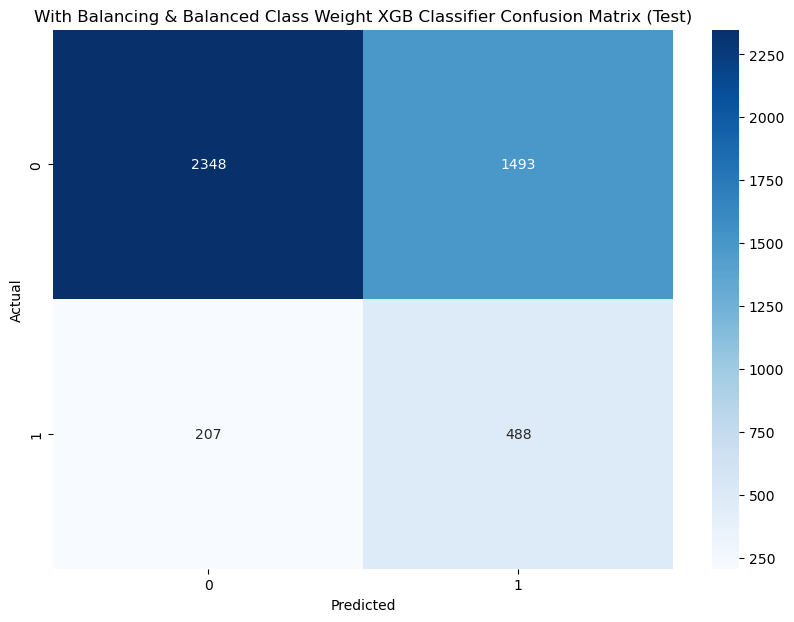



Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlanning_ratio',
       'Advisory_ratio',
       ...
       'G03DA02', 'B03BA03', 'G03FB05', 'S01AA13', 'A11JB', 'M01AE01',
       'N05AE04', 'N06AA09', 'R03AC03', 'B03BA01'],
      dtype='object', length=216)
(3426, 216)
RandomForestClassifier


/mnt/scratch/tmp/ipykernel_27129/3589805705.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Balanced Accuracy Scores:
[0.53343113 0.58160686 0.55608215 0.54973294 0.55183179]
Mean Balanced Accuracy: 0.5545369743474009
Cross-Validation F1 Scores:
[0.52690532 0.57914825 0.55345421 0.54700003 0.54266141]
Mean F1 Score: 0.5498338444838845
Balanced Accuracy (Test): 0.4624969937469938
F1 Score (Test): 0.4551651941857023
Confusion Matrix (Test):
[[ 91  64  43]
 [ 73 100  91]
 [ 33  68 123]]
              precision    recall  f1-score   support

           0       0.46      0.46      0.46       198
           1       0.43      0.38      0.40       264
           2       0.48      0.55      0.51       224

    accuracy                           0.46       686
   macro avg       0.46      0.46      0.46       686
weighted avg       0.46      0.46      0.46       686



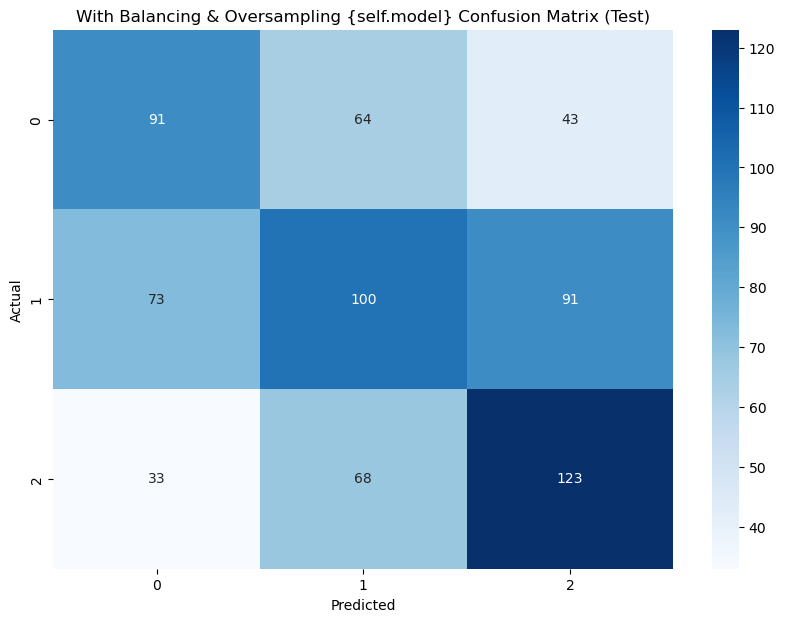

In [8]:
# options for algorithms: DecisionTreeClassifier, LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, MLPClassifier

binary_classifier_ins = Binary_classifier_Balancing_Balanced_Class_Weight(
    "GradientBoostingClassifier"
).readmission_noreadmission_binary_classifier()
print("\n")
multi_classifier_ins = Multi_classifier_Balancing_Oversampling(
    "RandomForestClassifier"
).readmission_multi_classifier()

# Final choices:
# Binary_classifier --> Oversampling_predicted_ML_df with class weight
# Multi_classifier -->  Balanced_predicted_BL_df with oversampling

In [9]:
# check the created CSVs
# df_I_BL = pd.read_csv('/home/kabank/work/workbench/dipendrp/new-data/Initial_predicted_BL_df.csv')
df_B_BL = pd.read_csv(
    predicted_start_path + "Balanced_predicted_BL_df.csv"
)  # the binary model which became balanced by XGBClassifier with class weight
# df_CW_BL = pd.read_csv('/home/kabank/work/workbench/dipendrp/new-data/Custom_weight_predicted_BL_df.csv')
# df_OS_BL = pd.read_csv('/home/kabank/work/workbench/dipendrp/new-data/Oversampling_predicted_BL_df.csv')
print(len(df_B_BL))
print(df_B_BL["predicted_Binary_label"].value_counts())
# print(df_BL.head())

# df_I_ML = pd.read_csv('/home/kabank/work/workbench/dipendrp/new-data/Initial_predicted_ML_df.csv')
# df_B_ML = pd.read_csv('/home/kabank/work/workbench/dipendrp/new-data/Balanced_predicted_ML_df.csv')
# df_CW_ML = pd.read_csv('/home/kabank/work/workbench/dipendrp/new-data/Custom_weight_predicted_ML_df.csv')
df_OS_ML = pd.read_csv(
    predicted_start_path + "Oversampling_predicted_ML_df.csv"
)  # the multi-class model which became oversampled by Logistic Regression with oversampling
print(len(df_OS_ML))
# print(df_ML.columns)
print(df_OS_ML["predicted_Multi_label"].value_counts())
# print(df_ML['episode_id'].nunique())

22676
predicted_Binary_label
0    12777
1     9899
Name: count, dtype: int64
3426
predicted_Multi_label
1    1308
2    1137
0     981
Name: count, dtype: int64


In [10]:
# check the length of created dataframes
print(len(final_episodes))
print(len(final_episodes1))
print(len(final_episodes2))
print(len(final_episodes1_episode_id))
print(len(final_episodes2_episode_id))

22676
22676
3426
22676
3426


# Comparing with initial solution
in the initial solution, we gave these six labels to the data: <br>
labels' value count: label <br>
5    19250 <br>
0      878 <br>
1      721 <br>
2      718 <br>
4      662 <br>
3      447

In [11]:
# read data *****
final_episodes = pd.read_csv(
    "/home/kabank/workbench/.conda/analysis/kabank-data/final_episodes.csv"
)
fullHot_episodes = pd.read_csv(
    "/home/kabank/workbench/.conda/analysis/kabank-data/final_episodes4.csv"
)
Diag_med = pd.read_csv(
    "/home/kabank/workbench/.conda/analysis/kabank-data/new-data/Dummies_ICD10_ATC_100.csv"
)  # Using the columns for diagnoses (in ICD-10) and medications (in ATC level 5)

# required changes *****
final_episodes.rename(
    columns={"var_no_dates_permonth": "SD_CareEvent_PerMonth"}, inplace=True
)


# merge to add some required columns *****
final_episodes = pd.merge(
    final_episodes,
    fullHot_episodes[
        [
            "episode_id",
            "num_diagnoses",
            "num_medications",
            "gender_0",
            "F",
            "M",
            "MiddleChildhood",
            "Preschooler",
            "Teenager",
        ]
    ],
    on="episode_id",
    how="inner",
)
final_episodes = pd.merge(
    final_episodes[
        [
            "episode_id",
            "tillnextepisode",
            "Length_of_Episode",
            "Count_visit",
            "SD_CareEvent_PerMonth",
            "num_diagnoses",
            "num_medications",
            "Inpatient_day_ratio",
            "Outpatient_ratio",
            "Therapy_ratio",
            "TreatmentPlanning_ratio",
            "Advisory_ratio",
            "gender_0",
            "F",
            "M",
            "MiddleChildhood",
            "Preschooler",
            "Teenager",
        ]
    ],
    Diag_med,
    on="episode_id",
    how="left",
)

# Encoding 'tillnextepisode' into labels:
le = LabelEncoder()
final_episodes["label"] = le.fit_transform(
    pd.cut(
        final_episodes["tillnextepisode"],
        bins=[float("-inf"), 0, 180, 365, 730, 1095, float("inf")],
        labels=[
            "not-re-admitted",
            "re-admitted in 0-180 days",
            "re-admitted in 180-365 days",
            "re-admitted in 365-730 days",
            "re-admitted in 730-1095 days",
            "re-admitted in more than 1095 days",
        ],
    )
)
# labels with value counts *****
print("labels' value count:", final_episodes["label"].value_counts())
print(final_episodes["label"].unique())

# Selecting independent features
features = final_episodes.iloc[:, 2:-1].columns

X = final_episodes[features]
y = final_episodes["label"]

# Features in use:
print("Features:\n", X.columns)

# Remove rows with NaN in the target variable
X = X.copy()
X.fillna(0, inplace=True)
X = X[~y.isna()]
y = y.dropna()

# Splitting the data into training and testing sets *****
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Calculate class weights
class_weights = compute_class_weight("balanced", classes=np.unique(y), y=y)
class_weight = dict(zip(np.unique(final_episodes["label"]), class_weights))

# Creating a decision tree classifier with class weights
NN = MLPClassifier(random_state=42, learning_rate="adaptive", max_iter=1000)

# Training the model
NN.fit(X_train_scaled, y_train)

# Making predictions on the test set
predictions_val = NN.predict(X_val_scaled)
predictions_test = NN.predict(X_test_scaled)

# Evaluate the model
balanced_accuracy_val = balanced_accuracy_score(y_val, predictions_val)
f1_val = f1_score(
    y_val, predictions_val, average="weighted"
)  # Using 'weighted' for multiclass problems
conf_matrix_val = confusion_matrix(y_val, predictions_val)

balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
f1_test = f1_score(
    y_test, predictions_test, average="weighted"
)  # Using 'weighted' for multiclass problems
conf_matrix_test = confusion_matrix(y_test, predictions_test)


print(
    "This is the results for With diagnoses and medications and with DecisionTreeClassifier:"
)
print(f"Balanced Accuracy (Validation): {balanced_accuracy_val}")
print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")

print("Confusion Matrix_val:")
print(conf_matrix_val)
print("Confusion Matrix_test:")
print(conf_matrix_test)

# Create a StratifiedKFold cross-validation object *****
X_train_scaled = pd.DataFrame(X_train_scaled)
X_val_scaled = pd.DataFrame(X_val_scaled)

X_train_val_scaled = pd.concat([X_train_scaled, X_val_scaled])
y_train_val = pd.concat([y_train, y_val])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(balanced_accuracy_score)

# Perform cross-validation on the combined training and validation sets
cv_scores = cross_val_score(NN, X_train_val_scaled, y_train_val, cv=cv, scoring=scorer)

# Display cross-validation results
print("Cross-Validation Accuracy Scores:")
print(cv_scores)
print(f"Mean Accuracy: {np.mean(cv_scores)}")

print(f"f1_val: {f1_val}")
print(f"f1_test: {f1_test}")
# Generate the classification report
report = classification_report(y_test, predictions_test)

print(report)

labels' value count: label
5    19250
0      878
1      721
2      718
4      662
3      447
Name: count, dtype: int64
[5 1 4 2 3 0]
Features:
 Index(['Length_of_Episode', 'Count_visit', 'SD_CareEvent_PerMonth',
       'num_diagnoses', 'num_medications', 'Inpatient_day_ratio',
       'Outpatient_ratio', 'Therapy_ratio', 'TreatmentPlanning_ratio',
       'Advisory_ratio',
       ...
       'G03DA02', 'B03BA03', 'G03FB05', 'S01AA13', 'A11JB', 'M01AE01',
       'N05AE04', 'N06AA09', 'R03AC03', 'B03BA01'],
      dtype='object', length=216)
This is the results for With diagnoses and medications and with DecisionTreeClassifier:
Balanced Accuracy (Validation): 0.1777054776183337
Balanced Accuracy (Test): 0.18324424962216312
Confusion Matrix_val:
[[   1    2    1    0    0   88]
 [   1    1    3    0    2   80]
 [   1    1    0    1    3   50]
 [   1    2    1    2    1   43]
 [   1    0    0    1    3   58]
 [  25   15   20   11   13 1836]]
Confusion Matrix_test:
[[   3    1    4    2    0   